# Paris - City of Light
## Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## I. Introduction: Business Problem <a name="introduction"></a>

In this project we will try to help the **Mayor of Paris** and his colleagues nearby Paris to adjust the **City policies** in order to encourage **social diversity** and to increase the **attractiveness of the neighborhoods**.

Paris is a tremendous city of 2 million inhabitants, with a very rich offer of culture, history but also gastronomy and nature. Around, the "Ile de France" region is the biggest european region in terms of population and GDP. Real estate is quite expensive, and there are important discrepancies among the 20 Paris districts ("Arrondissements") and the cities which are very close to Paris.

Our project will focus on East Paris (10 arrondissements) and 10 surrounding cities close to East Paris. Data collection and interpretation will focus on two distinct parts:
- first, we will examine the **real estate** price per "Arrondissement" or city, based on the available public data of Real Estate transactions. We will calculate the average price per square meter per city.
- second, we will find the most **popular venues** and segment the neighborhoods according to the typology of their venues. Of course, Foursquera will be used to collect the associated data.

Once we have the Real Estate prices associated to each Quartier and the Venues profile, we will try to find a **correlation** between the two types of data and describe what is the **venue segment associated with a "expensive", "medium" and "low price" neighborhood**.

We will than use then our data science powers to make some recommendation for the Mayor in order to adjust the City Policies. Particularly, we will try to find **what kind of venues** should be encouraged in order to increase the **attractiveness of the low price neighborhoods**.

## II. Data <a name="data"></a>

Let's start by importing the necessary libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### II.1 The geographical region we will study

The geographical region we will focus on is East Paris and the cities close to paris on it's East side.

Let's start by having a look on this part of map.

In [2]:
def paris_east ():
    latitude = 48.8534
    longitude = 2.4488
    # create Paris east Map map and display it
    return folium.Map(location=[latitude, longitude], zoom_start=13)

# display the map of East Paris
paris_east_map = paris_east()

paris_east_map

Let's mark on the map the boundaries of the **Cities** and **"Arrondissements"** we are interested in. 

We will use for this the GeoJson file available on https://france-geojson.gregoiredavid.fr

In [3]:
!wget --quiet https://france-geojson.gregoiredavid.fr/repo/regions/ile-de-france/communes-ile-de-france.geojson -O communes-ile-de-france.geojson

def paris_cities (paris_map):

    #windows version of wget
    #import wget

    url = 'https://france-geojson.gregoiredavid.fr/repo/regions/ile-de-france/communes-ile-de-france.geojson'
    #filename = wget.download(url)

    communes_ile_de_france = r'communes-ile-de-france.geojson'
    #print(communes_ile_de_france)
    folium.GeoJson(
        communes_ile_de_france
    ).add_to(paris_map)

    return paris_map

paris_cities(paris_east_map)    
paris_east_map

'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


The **city_list** is the collection of ZIP codes corresponding to the cities or Paris Arrondissements we are interested in

In [4]:
city_list = [75003, 75004, 75005, 75010, 75011, 75012, 75013, 75018, 75019, 75020, 93100, 93110, 93170, 93230, 93260, 93310, 93500, 94120, 94130, 94160, 94220, 94300, 94340, 94410]

### II.2 Data related to real estate transactions

Now let's collect the data associated with the real estate transactions in thsi region.

This data is public, and a full description (in French) can be found on the site below:
https://www.data.gouv.fr/fr/datasets/demandes-de-valeurs-foncieres-geolocalisees/

The brute data can be downloaded using the site https://www.data.gouv.fr/fr/datasets/les-communes-d-ile-de-france-idf/

I have uploaded into the IBM cloud the files corresponding to the real estate sales in 2018 in 3 departments from Ile de France:
    - 75 - Paris
    - 93 - Seine Saint Denis
    - 94 - Val de Marne

They correspond to teh Paris East Region we want to study.

The hidden code below import brute data into 3 pandas Dataframes

In [ ]:
# The code was removed by Watson Studio for sharing.

In [5]:
import os
os.getcwd()

'D:\\Python\\WPy64-3741\\notebooks\\coursera_capstone'

In [6]:
#windows version

df_data_1 = pd.read_csv('D:\\Python\\WPy64-3741\\notebooks\\coursera_capstone\\Data\\75_2018.csv')
df_data_2 = pd.read_csv('D:\\Python\\WPy64-3741\\notebooks\\coursera_capstone\\Data\\93_2018.csv')
df_data_3 = pd.read_csv('D:\\Python\\WPy64-3741\\notebooks\\coursera_capstone\\Data\\94_2018.csv')

D:\Python\WPy64-3741\python-3.7.4.amd64\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,20,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
D:\Python\WPy64-3741\python-3.7.4.amd64\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (14,17,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Let's concatenate these data into a sigle dataframe which we will call **restate_primary_data**. 

We get approx. 156,000 lines corresponding to unitary transactions on flats, houses, parkings, shops etc. sold in 2018 in these 3 departments.

In [7]:
df_list = [df_data_1, df_data_2, df_data_3]
restate_primary_data = pd.concat(df_list)

print (restate_primary_data.shape)
restate_primary_data.head()

(156424, 40)


id_mutation date_mutation  numero_disposition nature_mutation  \
0  2018-1276175    2018-01-04                   1           Vente   
1  2018-1276176    2018-01-09                   1           Vente   
2  2018-1276177    2018-01-05                   1           Vente   
3  2018-1276177    2018-01-05                   1           Vente   
4  2018-1276178    2018-01-03                   1           Vente   

   valeur_fonciere  adresse_numero adresse_suffixe  adresse_nom_voie  \
0        1202000.0            10.0             NaN        AV PERCIER   
1         130000.0            20.0             NaN  RUE SAINT CLAUDE   
2          51000.0            24.0             NaN     RUE TREILHARD   
3          51000.0            24.0             NaN     RUE TREILHARD   
4          15000.0            12.0             NaN         RUE VOLTA   

  adresse_code_voie  code_postal  code_commune              nom_commune  \
0              7250      75008.0         75108  Paris 8e Arrondissement   
1              8520      75003.0         75103  Paris 3e Arrondissement   
2              9429      75008.0         75108  Paris 8e Arrondissement   
3              9429      75008.0         75108  Paris 8e Arrondissement   
4              9905      75003.0         75103  Paris 3e Arrondissement   

   code_departement  ancien_code_commune ancien_nom_commune     id_parcelle  \
0                75                  NaN                NaN  75108000CJ0003   
1                75                  NaN                NaN  75103000AL0072   
2                75                  NaN                NaN  75108000CI0004   
3                75                  NaN                NaN  75108000CI0004   
4                75                  NaN                NaN  75103000AE0136   

   ancien_id_parcelle numero_volume lot1_numero  lot1_surface_carrez  \
0                 NaN           NaN          77                159.2   
1                 NaN           NaN         206                  NaN   
2                 NaN           NaN          20                  NaN   
3                 NaN           NaN          27                  NaN   
4                 NaN           NaN           7                  8.3   

  lot2_numero  lot2_surface_carrez  lot3_numero  lot3_surface_carrez  \
0          78                  NaN         79.0                  NaN   
1         213                  NaN        214.0                  NaN   
2         NaN                  NaN          NaN                  NaN   
3         NaN                  NaN          NaN                  NaN   
4         NaN                  NaN          NaN                  NaN   

   lot4_numero  lot4_surface_carrez  lot5_numero  lot5_surface_carrez  \
0          NaN                  NaN          NaN                  NaN   
1        216.0                  NaN          NaN                  NaN   
2          NaN                  NaN          NaN                  NaN   
3          NaN                  NaN          NaN                  NaN   
4          NaN                  NaN          NaN                  NaN   

   nombre_lots  code_type_local   type_local  surface_reelle_bati  \
0            3              2.0  Appartement                120.0   
1            4              2.0  Appartement                 22.0   
2            1              3.0   Dépendance                  NaN   
3            1              3.0   Dépendance                  NaN   
4            1              2.0  Appartement                  9.0   

   nombre_pieces_principales code_nature_culture nature_culture  \
0                        2.0                 NaN            NaN   
1                        1.0                 NaN            NaN   
2                        0.0                 NaN            NaN   
3                        0.0                 NaN            NaN   
4                        1.0                 NaN            NaN   

  code_nature_culture_speciale nature_culture_speciale  surface_terrain  \
0                          NaN  

We will keep only 13 usefull columns ans perform some data cleaning.

In [8]:
restate_primary_data = restate_primary_data[['id_mutation', 'date_mutation', 'numero_disposition', 'nature_mutation', \
                                             'valeur_fonciere', 'adresse_numero', 'adresse_nom_voie', 'code_postal', 'nom_commune', \
                                             'type_local', 'surface_reelle_bati', 'nombre_pieces_principales', 'longitude', 'latitude']]
restate_primary_data[['numero_disposition']] = 1
restate_primary_data.replace({'adresse_numero': np.NaN}, value=0, inplace=True)
restate_primary_data = restate_primary_data.astype({'adresse_numero': 'int64'}, copy=False)
restate_primary_data.replace({'code_postal': np.NaN}, value=0, inplace=True)
restate_primary_data = restate_primary_data.astype({'code_postal': 'int64'}, copy=False)
restate_primary_data.replace({'nombre_pieces_principales': np.NaN}, value=0, inplace=True)
restate_primary_data = restate_primary_data.astype({'nombre_pieces_principales': 'int64'}, copy=False)
restate_primary_data.replace({'surface_reelle_bati': np.NaN}, value=0, inplace=True)
print (restate_primary_data.shape)
restate_primary_data.head()

(156424, 14)


id_mutation date_mutation  numero_disposition nature_mutation  \
0  2018-1276175    2018-01-04                   1           Vente   
1  2018-1276176    2018-01-09                   1           Vente   
2  2018-1276177    2018-01-05                   1           Vente   
3  2018-1276177    2018-01-05                   1           Vente   
4  2018-1276178    2018-01-03                   1           Vente   

   valeur_fonciere  adresse_numero  adresse_nom_voie  code_postal  \
0        1202000.0              10        AV PERCIER        75008   
1         130000.0              20  RUE SAINT CLAUDE        75003   
2          51000.0              24     RUE TREILHARD        75008   
3          51000.0              24     RUE TREILHARD        75008   
4          15000.0              12         RUE VOLTA        75003   

               nom_commune   type_local  surface_reelle_bati  \
0  Paris 8e Arrondissement  Appartement                120.0   
1  Paris 3e Arrondissement  Appartement                 22.0   
2  Paris 8e Arrondissement   Dépendance                  0.0   
3  Paris 8e Arrondissement   Dépendance                  0.0   
4  Paris 3e Arrondissement  Appartement                  9.0   

   nombre_pieces_principales  longitude   latitude  
0                          2   2.315005  48.874705  
1                          1   2.365335  48.860248  
2                          0   2.313122  48.877067  
3                          0   2.313122  48.877067  
4                          1   2.357140  48.864804

Here below is the list of zip codes for the Arrondissements and Cities we would like to study.

We will include the data for these cities into a new dataframe called **df_east_paris_primary**. We get a reduced list of approx. **56,000** elementary transactions.

In [9]:
city_list = [75003, 75004, 75005, 75010, 75011, 75012, 75013, 75018, 75019, 75020, 93100, 93110, 93170, 93230, 93260, 93310, 93500, 94120, 94130, 94160, 94220, 94300, 94340, 94410]

for code_city in city_list:
    if code_city == 75003:
        df_east_paris_primary = restate_primary_data.loc[restate_primary_data['code_postal'] == code_city]
    else:
        df_east_paris_primary = df_east_paris_primary.append(restate_primary_data.loc[restate_primary_data['code_postal'] == code_city])

df_east_paris_primary.shape

(55786, 14)

Let's take a look on how many elementary transactions we have per Arrondissement or City for our **city_list**

In [10]:
df_east_paris_primary.reset_index(drop=True, inplace=True)
df_east_paris_primary.groupby(['code_postal'])['nom_commune'].value_counts()

code_postal  nom_commune             
75003        Paris 3e Arrondissement     1347
75004        Paris 4e Arrondissement     1378
75005        Paris 5e Arrondissement     1383
75010        Paris 10e Arrondissement    3254
75011        Paris 11e Arrondissement    4832
75012        Paris 12e Arrondissement    3703
75013        Paris 13e Arrondissement    2883
75018        Paris 18e Arrondissement    6245
75019        Paris 19e Arrondissement    5134
75020        Paris 20e Arrondissement    3658
93100        Montreuil                   2693
93110        Rosny-sous-Bois             1813
93170        Bagnolet                     984
93230        Romainville                 5685
93260        Les Lilas                   1011
93310        Le Pré-Saint-Gervais         495
93500        Pantin                      1650
94120        Fontenay-sous-Bois          1630
94130        Nogent-sur-Marne            1342
94160        Saint-Mandé                  869
94220        Charenton-le-Pont            

What type of transactions do we have here?

In [11]:
df_east_paris_primary.groupby(['numero_disposition'])['nature_mutation'].value_counts()

numero_disposition  nature_mutation                   
1                   Vente                                 50583
                    Vente en l'état futur d'achèvement     4542
                    Echange                                 382
                    Adjudication                            181
                    Vente terrain à bâtir                    81
                    Expropriation                            17
Name: nature_mutation, dtype: int64

And how many objects have been transacted (appartment, houses, shops etc...)?

In [12]:
df_east_paris_primary.groupby(['numero_disposition'])['type_local'].value_counts()

numero_disposition  type_local                              
1                   Appartement                                 33133
                    Dépendance                                  12819
                    Local industriel. commercial ou assimilé     3842
                    Maison                                       1240
Name: type_local, dtype: int64

We will now keep only simple classical transactions (sale) and we will add category columns for the type of object sold (appartment, house etc.)

In [13]:
index_coll = df_east_paris_primary[df_east_paris_primary['nature_mutation'] == 'Adjudication'].index
index_coll = index_coll.append(df_east_paris_primary[df_east_paris_primary['nature_mutation'] == 'Echange'].index)
index_coll = index_coll.append(df_east_paris_primary[df_east_paris_primary['nature_mutation'] == 'Expropriation'].index)
index_coll = index_coll.append(df_east_paris_primary[df_east_paris_primary['nature_mutation'] == 'Vente terrain à bâtir'].index)
index_coll = index_coll.sort_values()
df_east_paris_primary.drop(index_coll, inplace=True)
df_east_paris_primary = pd.concat([df_east_paris_primary,pd.get_dummies(df_east_paris_primary['type_local'])], axis=1)
df_east_paris_primary.groupby(['numero_disposition'])['nature_mutation'].value_counts()
df_east_paris_primary.head()

id_mutation date_mutation  numero_disposition nature_mutation  \
0  2018-1276176    2018-01-09                   1           Vente   
1  2018-1276178    2018-01-03                   1           Vente   
2  2018-1276181    2018-01-09                   1           Vente   
3  2018-1276181    2018-01-09                   1           Vente   
4  2018-1276181    2018-01-09                   1           Vente   

   valeur_fonciere  adresse_numero  adresse_nom_voie  code_postal  \
0         130000.0              20  RUE SAINT CLAUDE        75003   
1          15000.0              12         RUE VOLTA        75003   
2        1840000.0             251  RUE SAINT MARTIN        75003   
3        1840000.0             251  RUE SAINT MARTIN        75003   
4        1840000.0             251  RUE SAINT MARTIN        75003   

               nom_commune   type_local  surface_reelle_bati  \
0  Paris 3e Arrondissement  Appartement                 22.0   
1  Paris 3e Arrondissement  Appartement                  9.0   
2  Paris 3e Arrondissement   Dépendance                  0.0   
3  Paris 3e Arrondissement   Dépendance                  0.0   
4  Paris 3e Arrondissement  Appartement                180.0   

   nombre_pieces_principales  longitude   latitude  Appartement  Dépendance  \
0                          1   2.365335  48.860248            1           0   
1                          1   2.357140  48.864804            1           0   
2                          0   2.353682  48.866408            0           1   
3                          0   2.353682  48.866408            0           1   
4                          7   2.353682  48.866408            1           0   

   Local industriel. commercial ou assimilé  Maison  
0                                         0       0  
1                                         0       0  
2                                         0       0  
3                                         0       0  
4                                         0       0

Now let's group the elements per transaction. We will keep a **single line per transaction** (while in the original files there was a line per object sold).

At the end, we havve approx. **32,000** of global transactions concerning this geographical zone.

In [14]:
df1 = df_east_paris_primary.groupby(['id_mutation', 'date_mutation', 'nature_mutation', 'code_postal', 'nom_commune'])\
    [['adresse_numero', 'adresse_nom_voie','valeur_fonciere', 'longitude', 'latitude']].max().reset_index()

df2 = df_east_paris_primary.groupby(['id_mutation'])\
    [['numero_disposition', 'surface_reelle_bati', 'Appartement', 'Dépendance', 'Local industriel. commercial ou assimilé', 'Maison', 'nombre_pieces_principales']].sum().reset_index()

df3 = df1.join(df2.set_index('id_mutation'), on='id_mutation')
df3 = df3.astype({'Appartement': 'int64'}, copy=False)
df3 = df3.astype({'Dépendance': 'int64'}, copy=False)
df3 = df3.astype({'Local industriel. commercial ou assimilé': 'int64'}, copy=False)
df3 = df3.astype({'Maison': 'int64'}, copy=False)
print (df3.shape)
df3.head()

(32447, 17)


id_mutation date_mutation nature_mutation  code_postal  nom_commune  \
0  2018-1195952    2018-01-03           Vente        93230  Romainville   
1  2018-1195953    2018-01-08           Vente        93500       Pantin   
2  2018-1195954    2018-01-05           Vente        93170     Bagnolet   
3  2018-1195955    2018-01-05           Vente        93500       Pantin   
4  2018-1195958    2018-01-05           Vente        93260    Les Lilas   

   adresse_numero   adresse_nom_voie  valeur_fonciere  longitude   latitude  \
0              25  BD EMILE GENEVOIX         230000.0   2.435743  48.881934   
1               4      RUE LAPEROUSE          90000.0   2.393240  48.900227   
2               2  RUE DES LORIETTES         222000.0   2.420057  48.872363   
3              31         RUE DELIZY         278000.0   2.408445  48.896071   
4              45   BD DE LA LIBERTE         626400.0   2.420566  48.880405   

   numero_disposition  surface_reelle_bati  Appartement  Dépendance  \
0                   2                 59.0            1           1   
1                   1                 40.0            1           0   
2                   1                 55.0            1           0   
3                   2                 52.0            1           1   
4                   1                110.0            0           0   

   Local industriel. commercial ou assimilé  Maison  nombre_pieces_principales  
0                                         0       0                          3  
1                                         0       0                          3  
2                                         0       0                          3  
3                                         0       0                          2  
4                                         0       1                          5

We will now keep only the transactions concerning the **Appartments** and drop everything else. 

Final data will be stored in **east_paris_transactions** dataframe

In [15]:
index_coll = df3[df3['Local industriel. commercial ou assimilé'] >= 1].index
index_coll = index_coll.append(df3[df3['Maison'] >= 1].index)
index_coll = index_coll.append(df3[df3['Appartement'] < 1].index)
east_paris_transactions = df3.drop(index_coll)
east_paris_transactions.reset_index(drop=True, inplace=True)
print(east_paris_transactions.shape)

(23904, 17)


We will now calculate and enrich the dataframe with the **price per square meter**.

In [16]:
#insert a new column - prix au m2
east_paris_transactions['nombre_transactions'] = 1
east_paris_transactions['prix_m2'] = east_paris_transactions['valeur_fonciere'] / east_paris_transactions['surface_reelle_bati']

east_paris_transactions.head()

id_mutation date_mutation nature_mutation  code_postal  nom_commune  \
0  2018-1195952    2018-01-03           Vente        93230  Romainville   
1  2018-1195953    2018-01-08           Vente        93500       Pantin   
2  2018-1195954    2018-01-05           Vente        93170     Bagnolet   
3  2018-1195955    2018-01-05           Vente        93500       Pantin   
4  2018-1195960    2018-01-05           Vente        93500       Pantin   

   adresse_numero   adresse_nom_voie  valeur_fonciere  longitude   latitude  \
0              25  BD EMILE GENEVOIX         230000.0   2.435743  48.881934   
1               4      RUE LAPEROUSE          90000.0   2.393240  48.900227   
2               2  RUE DES LORIETTES         222000.0   2.420057  48.872363   
3              31         RUE DELIZY         278000.0   2.408445  48.896071   
4             143     AV JEAN LOLIVE         695000.0   2.412250  48.893774   

   numero_disposition  surface_reelle_bati  Appartement  Dépendance  \
0                   2                 59.0            1           1   
1                   1                 40.0            1           0   
2                   1                 55.0            1           0   
3                   2                 52.0            1           1   
4                   3                107.0            1           2   

   Local industriel. commercial ou assimilé  Maison  \
0                                         0       0   
1                                         0       0   
2                                         0       0   
3                                         0       0   
4                                         0       0   

   nombre_pieces_principales  nombre_transactions      prix_m2  
0                          3                    1  3898.305085  
1                          3                    1  2250.000000  
2                          3                    1  4036.363636  
3                          2                    1  5346.153846  
4                          5                    1  6495.327103

Let's take a look at the distribution of price per square meter in our data, city by city. We will use a boxplot graph.

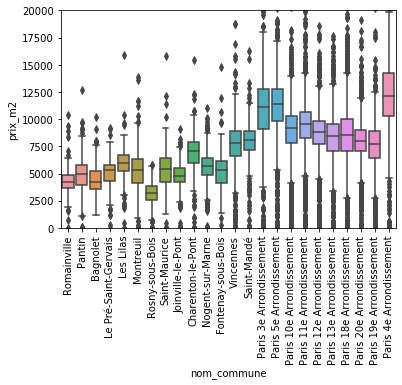

In [17]:
sns.boxplot(x="nom_commune", y="prix_m2", data=east_paris_transactions)
plt.ylim(0, 20000)
plt.xticks(rotation=90)
plt.autoscale(enable=True, axis='x')

So, depending on the cityes, median price go between **3000€/m²** and more than **12000€/m²**.

Let's take a look at the outliers, and simply drop them (prices per square meter above 20000€ or below 500€). The number of transactions we will keep per city is herebelow.

In [18]:
index_coll = east_paris_transactions[east_paris_transactions['prix_m2'] > 20000].index
index_coll = index_coll.append(east_paris_transactions[east_paris_transactions['prix_m2'] < 500].index)
east_paris_transactions = east_paris_transactions.drop(index_coll)
east_paris_transactions.reset_index(drop=True, inplace=True)
print(east_paris_transactions.shape)

east_paris_transactions.groupby(['code_postal', 'nom_commune'])['nombre_transactions'].sum()

(23367, 19)


code_postal  nom_commune             
75003        Paris 3e Arrondissement      760
75004        Paris 4e Arrondissement      524
75005        Paris 5e Arrondissement      824
75010        Paris 10e Arrondissement    1627
75011        Paris 11e Arrondissement    2561
75012        Paris 12e Arrondissement    1675
75013        Paris 13e Arrondissement    1576
75018        Paris 18e Arrondissement    3626
75019        Paris 19e Arrondissement    1829
75020        Paris 20e Arrondissement    2123
93100        Montreuil                   1035
93110        Rosny-sous-Bois              472
93170        Bagnolet                     312
93230        Romainville                  205
93260        Les Lilas                    275
93310        Le Pré-Saint-Gervais         198
93500        Pantin                       643
94120        Fontenay-sous-Bois           430
94130        Nogent-sur-Marne             572
94160        Saint-Mandé                  407
94220        Charenton-le-Pont            

#### To resume, we have now, in the dataframe east_paris_transactions the list of real estate transactions from 2018 in the cities of our choice, with the associated price / squere meter

#### This list contains approx. 23,000 transactions

### II.3 Divide geographical space in square tiles

Now let's analyse the geographical shape of our list of cities and divide this surface in a grid of 15x15 tiles.

In [19]:
bins_lat = np.linspace(min(east_paris_transactions['latitude']), max(east_paris_transactions['latitude']), 19)
lat_names = list(range(0,18))
east_paris_transactions['bins_lat'] = pd.cut(east_paris_transactions['latitude'], bins_lat, labels=lat_names, include_lowest=True)
bins_long = np.linspace(min(east_paris_transactions['longitude']), max(east_paris_transactions['longitude']), 19)
long_names = lat_names = list(range(0,18))
east_paris_transactions['bins_long'] = pd.cut(east_paris_transactions['longitude'], bins_long, labels=long_names, include_lowest=True)

east_paris_transactions.head()

id_mutation date_mutation nature_mutation  code_postal  nom_commune  \
0  2018-1195952    2018-01-03           Vente        93230  Romainville   
1  2018-1195953    2018-01-08           Vente        93500       Pantin   
2  2018-1195954    2018-01-05           Vente        93170     Bagnolet   
3  2018-1195955    2018-01-05           Vente        93500       Pantin   
4  2018-1195960    2018-01-05           Vente        93500       Pantin   

   adresse_numero   adresse_nom_voie  valeur_fonciere  longitude   latitude  \
0              25  BD EMILE GENEVOIX         230000.0   2.435743  48.881934   
1               4      RUE LAPEROUSE          90000.0   2.393240  48.900227   
2               2  RUE DES LORIETTES         222000.0   2.420057  48.872363   
3              31         RUE DELIZY         278000.0   2.408445  48.896071   
4             143     AV JEAN LOLIVE         695000.0   2.412250  48.893774   

   numero_disposition  surface_reelle_bati  Appartement  Dépendance  \
0                   2                 59.0            1           1   
1                   1                 40.0            1           0   
2                   1                 55.0            1           0   
3                   2                 52.0            1           1   
4                   3                107.0            1           2   

   Local industriel. commercial ou assimilé  Maison  \
0                                         0       0   
1                                         0       0   
2                                         0       0   
3                                         0       0   
4                                         0       0   

   nombre_pieces_principales  nombre_transactions      prix_m2 bins_lat  \
0                          3                    1  3898.305085       12   
1                          3                    1  2250.000000       15   
2                          3                    1  4036.363636       10   
3                          2                    1  5346.153846       14   
4                          5                    1  6495.327103       14   

  bins_long  
0        10  
1         6  
2         9  
3         8  
4         8

We will calculate now the average **price / square meter** and the **number of transactions** which occured in each tile.

In [20]:
tiles = east_paris_transactions.groupby(['bins_lat','bins_long'])['prix_m2'].mean().reset_index()
tiles.set_index(['bins_lat', 'bins_long'])

tiles2 = east_paris_transactions.groupby(['bins_lat','bins_long'])['nombre_transactions'].sum().reset_index()
tiles2.set_index(['bins_lat', 'bins_long'])

tiles= tiles.join(tiles2.set_index(['bins_lat', 'bins_long']), on=['bins_lat','bins_long'])
tiles = tiles.dropna().set_index(['bins_lat', 'bins_long']).reset_index()
tiles = tiles.astype({'nombre_transactions': 'int64'}, copy=False)
tiles.head()

bins_lat bins_long      prix_m2  nombre_transactions
0        0        12  5189.112510                    6
1        0        13  4731.721471                  131
2        0        14  4788.432368                   49
3        0        15  4262.313225                   14
4        1         1  8161.830850                   42

Let's enrich this tile list with the geographical information (latitude, longitude, square borders), and also the postal address in the center of each tile.

In [21]:
import time
#return a minimal address as a string from a raw location got from a geolocator
def get_address_from_geolocator (location):

    try:
        road = location['address']['road']
    except:
        try:
            road = location['address']['cycleway']
        except:
            try:
                road = location['address']['pedestrian']
            except:
                try:
                    road = location['address']['footway']
                except:
                    try:
                        road = location['address']['path']
                    except:
                        try:
                            road = location['address']['suburb']
                        except:
                            road = 'No road'
                            print('Warning, no road:', location)

    try:
        postcode = location['address']['postcode']
    except:
        postcode = 'No code'
        print('Warning, no code:',location)

    try:
        city = location['address']['city_district']
    except:
        try:
            city = location['address']['town']
        except:
            try:
                city = location['address']['city']
            except:
                city = 'No city'
                print('Warning, no city:', location)
            
    #   tiles.loc[i, 'tile_id'] = s
    address = "{}, {}, {}".format(road, postcode, city)
    return address

In [22]:
geolocator = Nominatim(user_agent="paris_explorer")

for lat in range(0, 20):
    index_list = tiles[tiles['bins_lat']==lat].index
    for k in index_list:
        tiles.at[k, 'lat_s'] = bins_lat[lat]
        tiles.at[k, 'lat_n'] = bins_lat[lat+1]
        tiles.at[k, 'latitude'] = (bins_lat[lat] + bins_lat[lat+1])/2

for long in range(0, 20):
    index_list = tiles[tiles['bins_long']==long].index
    for k in index_list:
        tiles.at[k, 'long_w'] = bins_long[long]
        tiles.at[k, 'long_e'] = bins_long[long+1]
        tiles.at[k, 'longitude'] = (bins_long[long] + bins_long[long+1])/2

for i in tiles.index:
    s = "{:02d}_{:02d}".format (tiles.loc[i, 'bins_lat'], tiles.loc[i, 'bins_long'],)
    tiles.loc[i, 'tile_id'] = s
    for j in range(0, 5):
        try:
            location = geolocator.reverse((tiles.loc[i,'latitude'], tiles.loc[i,'longitude']))
            break
        except:
            time.sleep(3)
    adr = get_address_from_geolocator(location.raw)
    tiles.loc[i, 'address'] = adr
    print(s, adr)
    
tiles.head()

00_12 Avenue Joffre, 94700, Maisons-Alfort
00_13 Rue du Maréchal Leclerc, 94410, Saint-Maurice
00_14 Villa de la Grotte, 94340, Joinville-le-Pont
00_15 Rue Diderot, 94500, Champigny-sur-Marne
01_01 Allée du Bardo, 75014, Paris 14e Arrondissement
01_02 Rue Gouthière, 75013, Paris 13e Arrondissement
01_03 Rue Gandon, 75013, Paris 13e Arrondissement
01_04 Avenue de la Porte d'Ivry, 75013, Paris 13e Arrondissement
01_07 Autoroute de l’Est, 94220, Charenton-le-Pont
01_08 Rue Saint-Pierre, 94220, Charenton-le-Pont
01_09 Rue Adrien Damalix, 94410, Saint-Maurice
01_10 Impasse Junot, 94410, Saint-Maurice
01_11 Route Nouvelle, 75012, Paris 12e Arrondissement
01_13 Autoroute de l’Est, 75012, Paris 12e Arrondissement
01_14 Rue du Port, 94340, Joinville-le-Pont
01_15 Boulevard de Polangis, 94340, Joinville-le-Pont
02_01 Avenue Reille, 75014, Paris 14e Arrondissement
02_02 Rue de Tolbiac, 75013, Paris 13e Arrondissement
02_03 Rue de Tolbiac, 75013, Paris 13e Arrondissement
02_04 Rue Albert, 75013, P

11_09 Rue de Noisy le Sec, 93260, Les Lilas
11_10 Rue Anatole France, 93170, Bagnolet
11_11 Boulevard Henri Barbusse, 93230, Romainville
11_12 Avenue du Docteur Fernand Lamaze, 93100, Montreuil
11_13 Allée Joyeuse, 93100, Montreuil
11_14 Allée des Myosotis, 93110, Rosny-sous-Bois
11_15 Boulevard Gabriel Péri, 93110, Rosny-sous-Bois
11_16 Rue des Berthauds, 93110, Rosny-sous-Bois
11_17 Impasse de l'Aubépine, 93110, Rosny-sous-Bois
12_00 Rue de Bruxelles, 75009, Paris 9e Arrondissement
12_01 Rue d'Orsel, 75018, Paris 18e Arrondissement
12_02 Rue Guy Patin, 75010, Paris 10e Arrondissement
12_03 Rue Philippe de Girard, 75010, Paris 10e Arrondissement
12_04 Quai de la Loire, 75019, Paris 19e Arrondissement
12_05 Rue André Dubois, 75019, Paris 19e Arrondissement
12_06 Rue de la Solidarité, 75019, Paris 19e Arrondissement
12_07 Rue Anatole France, 93310, Le Pré-Saint-Gervais
12_08 Rue Jules Auffret, 93310, Le Pré-Saint-Gervais
12_09 Rue Paul Langevin, 93260, Les Lilas
12_10 Sente de la Ferme,

bins_lat bins_long      prix_m2  nombre_transactions      lat_s      lat_n  \
0        0        12  5189.112510                    6  48.811961  48.817690   
1        0        13  4731.721471                  131  48.811961  48.817690   
2        0        14  4788.432368                   49  48.811961  48.817690   
3        0        15  4262.313225                   14  48.811961  48.817690   
4        1         1  8161.830850                   42  48.817690  48.823419   

    latitude    long_w    long_e  longitude tile_id  \
0  48.814826  2.446647  2.456692   2.451669   00_12   
1  48.814826  2.456692  2.466738   2.461715   00_13   
2  48.814826  2.466738  2.476783   2.471761   00_14   
3  48.814826  2.476783  2.486829   2.481806   00_15   
4  48.820555  2.336146  2.346191   2.341168   01_01   

                                           address  
0             Avenue Joffre, 94700, Maisons-Alfort  
1    Rue du Maréchal Leclerc, 94410, Saint-Maurice  
2     Villa de la Grotte, 94340, Joinville-le-Pont  
3          Rue Diderot, 94500, Champigny-sur-Marne  
4  Allée du Bardo, 75014, Paris 14e Arrondissement

Let's have a look of how these tiles map the list of cities and arrondissements we are interested in.

Prior, we will define a function **rectTile** which allows to create a json geometrical square object. Then, build a GeoJson file which contains the list of all our tiles.

In [23]:
def rectTile(tile_ids, long_w_list, long_e_list, lat_s_list, lat_n_list):
    
    tile_list=[]
    for tile_id, long_w, long_e, lat_s, lat_n,  in zip(tile_ids, long_w_list, long_e_list, lat_s_list, lat_n_list):
                 
        # print("tile_id ", tile_id)
        # return only relevant information for each nearby venue
        tile_list.append(
             {"type":"Feature",\
                "geometry":\
                  {"type":"Polygon",\
                     "coordinates":[[[long_w, lat_s],[long_w, lat_n],[long_e, lat_n],[long_e, lat_s]]]},\
                "properties":{"tile_id":tile_id}})
    return(tile_list)

east_tile_list = rectTile(tile_ids=tiles['tile_id'],
                                    long_w_list=tiles['long_w'],
                                    long_e_list=tiles['long_e'],
                                    lat_s_list=tiles['lat_s'],
                                    lat_n_list=tiles['lat_n']                                                                
                                  )

east_tiles = {"type":"FeatureCollection",\
"features": east_tile_list}

f = open('all_tiles.json', 'w')
json.dump(east_tiles, f)
f.close()

In [24]:
def paris_tiles (paris_map):
    workfile = r'all_tiles.json'
    print(workfile)

    folium.GeoJson(
        workfile
    ).add_to(paris_map)
    return (paris_map)

Now let's show the map, with the border of cities and the initial list of tiles we have built

In [25]:
paris_east_map = paris_east()

paris_east_map = paris_cities(paris_east_map)

paris_east_map = paris_tiles(paris_east_map)

paris_east_map

all_tiles.json


On the top of that, center the circles in which we will look for Foursquera venues. The optimal radius seems to be 370 meters. The centers of the circles are in the center of each tile. The circles are superposing a little bit. However, we can accept this, as this gives the venues in the proximity of each tile center. 

In [26]:
for lat, lon in zip(tiles['latitude'], tiles['longitude']):
    #print (lat, lon)
    folium.Circle([lat, lon], radius=400, color='blue', fill=False).add_to(paris_east_map)
paris_east_map

Looks good, but it is a little bit clumsy :-(

### II.4 Foursquera

In [27]:
# The code was removed by Watson Studio for sharing.
CLIENT_ID = 'WRGTBGWVIWD1S0LLK0GRGEARWM2GBYEQ1QOP0PSIPNBJHOUT' # your Foursquare ID
CLIENT_SECRET = 'VALOPUUYGGEAIWKNIW5WVQRIIGYRO2EZJ0LOTKT1JDXXECKF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Now, let's get the venues for the list of tiles we have built

In [28]:
def getNearbyVenues(tile_ids, latitudes, longitudes, radius=400, LIMIT=100):
    
    venues_list=[]
    for tile_id, lat, lng in zip(tile_ids, latitudes, longitudes):
                 
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        #print(url)
        # make the GET request
        for j in range(0, 5):
            try:
                time.sleep(0.5) 
                results = requests.get(url).json()["response"]['groups'][0]['items']
                break
            except:
                 time.sleep(3)                    
        
        print("tile_id ", tile_id, ": ", len(results), " venues")
        # return only relevant information for each nearby venue
        venues_list.append([(
            tile_id,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['tile_id',
                  'Tile Latitude', 
                  'Tile Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

paris_east_venues = getNearbyVenues(tile_ids=tiles['tile_id'],
                                    latitudes=tiles['latitude'],
                                    longitudes=tiles['longitude']
                                  )
print(paris_east_venues.shape)
paris_east_venues.tail(20)

tile_id  00_12 :  4  venues
tile_id  00_13 :  10  venues
tile_id  00_14 :  4  venues
tile_id  00_15 :  0  venues
tile_id  01_01 :  14  venues
tile_id  01_02 :  12  venues
tile_id  01_03 :  34  venues
tile_id  01_04 :  12  venues
tile_id  01_07 :  9  venues
tile_id  01_08 :  4  venues
tile_id  01_09 :  5  venues
tile_id  01_10 :  1  venues
tile_id  01_11 :  3  venues
tile_id  01_13 :  5  venues
tile_id  01_14 :  6  venues
tile_id  01_15 :  4  venues
tile_id  02_01 :  17  venues
tile_id  02_02 :  53  venues
tile_id  02_03 :  73  venues
tile_id  02_04 :  33  venues
tile_id  02_05 :  18  venues
tile_id  02_06 :  21  venues
tile_id  02_07 :  18  venues
tile_id  02_08 :  8  venues
tile_id  02_09 :  5  venues
tile_id  02_13 :  4  venues
tile_id  02_14 :  4  venues
tile_id  02_15 :  2  venues
tile_id  03_01 :  17  venues
tile_id  03_02 :  50  venues
tile_id  03_03 :  11  venues
tile_id  03_04 :  30  venues
tile_id  03_05 :  32  venues
tile_id  03_06 :  28  venues
tile_id  03_07 :  6  venues
ti

tile_id  Tile Latitude  Tile Longitude  \
4395   15_06      48.900762        2.391396   
4396   15_06      48.900762        2.391396   
4397   15_07      48.900762        2.401442   
4398   15_07      48.900762        2.401442   
4399   15_07      48.900762        2.401442   
4400   15_07      48.900762        2.401442   
4401   15_08      48.900762        2.411487   
4402   15_08      48.900762        2.411487   
4403   16_06      48.906491        2.391396   
4404   16_06      48.906491        2.391396   
4405   16_06      48.906491        2.391396   
4406   16_06      48.906491        2.391396   
4407   16_06      48.906491        2.391396   
4408   16_07      48.906491        2.401442   
4409   16_07      48.906491        2.401442   
4410   16_07      48.906491        2.401442   
4411   16_07      48.906491        2.401442   
4412   17_08      48.912220        2.411487   
4413   17_08      48.912220        2.411487   
4414   17_08      48.912220        2.411487   

                                                  Venue  Venue Latitude  \
4395                               Porte de la Villette       48.899272   
4396  Super Insolite - boutique en ligne de cadeaux ...       48.899533   
4397                                             MurMur       48.902748   
4398                                        Halle Papin       48.904150   
4399                                    La Cité Fertile       48.898687   
4400                                     RER Pantin [E]       48.897989   
4401                   Galerie Thaddaeus Ropac - Pantin       48.899350   
4402                                          Cafe Bleu       48.899462   
4403                  Sidi bousaïd (cuisine tunisienne)       48.904839   
4404                                           Superlav       48.905455   
4405                                La Villa Mais d'Ici       48.906391   
4406                                          KIngooroo       48.907874   
4407                    Maïs chaud (maïsssso, maïsssso)       48.903166   
4408                                        Halle Papin       48.904150   
4409                          Compagnie d'arc de Pantin       48.909057   
4410                                 le patio provencal       48.908628   
4411                                       Pantin Rugby       48.909736   
4412                             Parc Des Courtillières       48.912800   
4413                                 Boulangerie Louise       48.909757   
4414                        Pharmacie du pont de pierre       48.912543   

      Venue Longitude                Venue Category  
4395         2.387311                         Plaza  
4396         2.395620                     Gift Shop  
4397         2.401252                  Climbing Gym  
4398         2.400839         Performing Arts Venue  
4399         2.398871         General Entertainment  
4400         2.400438                 Train Station  
4401         2.408075                   Art Gallery  
4402         2.408030                   Coffee Shop  
4403         2.392877      Mediterranean Restaurant  
4404         2.394582                    Laundromat  
4405         2.387434         Performing Arts Venue  
4406         2.395802  Theme Park Ride / Attraction  
4407         2.392489                    Food Truck  
4408         2.400839         Performing Arts Venue  
4409         2.401340          Gym / Fitness Center  
4410         2.397452             French Restaurant  
4411         2.402935            Athletics & Sports  
4412         2.412086                        Garden  
4413         2.412532                        Bakery  
4414         2.415753                      Pharmacy

How many venues do we have? We get more than 4000 venues, covering all our tile space.

A quick histogram will help to understand how many venues we have per tile.

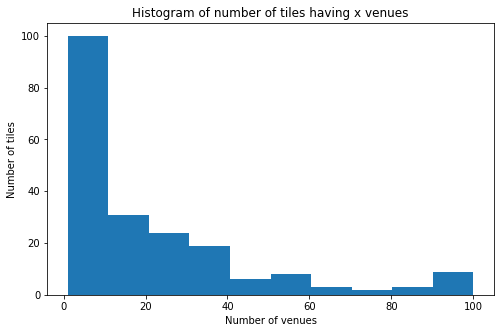

In [29]:
paris_east_venues['nombre_venues'] = 1
venues_per_tile = paris_east_venues.groupby(['tile_id','Tile Latitude', 'Tile Longitude'])['nombre_venues'].sum().reset_index()

# np.histogram returns 2 values
count, bin_edges = np.histogram(venues_per_tile['nombre_venues'])

#print(count) # frequency count
#print(bin_edges) # bin ranges, default = 10 bins

venues_per_tile['nombre_venues'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of number of tiles having x venues') # add a title to the histogram
plt.ylabel('Number of tiles') # add y-label
plt.xlabel('Number of venues') # add x-label

plt.show()

So, there are approx. 100 tiles on our area, having a very small (less than 10) number of interesting venues.

No let's add the number of venues to each tile of our **tiles** dataframe

In [30]:
tiles= tiles.join(venues_per_tile.set_index(['tile_id']), on=['tile_id'])

tiles.head()

bins_lat bins_long      prix_m2  nombre_transactions      lat_s      lat_n  \
0        0        12  5189.112510                    6  48.811961  48.817690   
1        0        13  4731.721471                  131  48.811961  48.817690   
2        0        14  4788.432368                   49  48.811961  48.817690   
3        0        15  4262.313225                   14  48.811961  48.817690   
4        1         1  8161.830850                   42  48.817690  48.823419   

    latitude    long_w    long_e  longitude tile_id  \
0  48.814826  2.446647  2.456692   2.451669   00_12   
1  48.814826  2.456692  2.466738   2.461715   00_13   
2  48.814826  2.466738  2.476783   2.471761   00_14   
3  48.814826  2.476783  2.486829   2.481806   00_15   
4  48.820555  2.336146  2.346191   2.341168   01_01   

                                           address  Tile Latitude  \
0             Avenue Joffre, 94700, Maisons-Alfort      48.814826   
1    Rue du Maréchal Leclerc, 94410, Saint-Maurice      48.814826   
2     Villa de la Grotte, 94340, Joinville-le-Pont      48.814826   
3          Rue Diderot, 94500, Champigny-sur-Marne            NaN   
4  Allée du Bardo, 75014, Paris 14e Arrondissement      48.820555   

   Tile Longitude  nombre_venues  
0        2.451669            4.0  
1        2.461715           10.0  
2        2.471761            4.0  
3             NaN            NaN  
4        2.341168           14.0

From the final list of tiles of interest, we will drop the tiles which have less than 20 real estate transactions and less then 4 venues.

In [80]:
tiles.replace({'nombre_venues': np.NaN}, value=0, inplace=True)
tiles = tiles.astype({'nombre_venues': 'int64'}, copy=False)
index_coll = tiles[tiles['nombre_transactions']<20].index
tiles=tiles.drop(index_coll)
tiles.reset_index(drop=True, inplace=True)
index_coll = tiles[tiles['nombre_venues']<4].index
tiles=tiles.drop(index_coll)
tiles.reset_index(drop=True, inplace=True)
print (tiles.shape)
tiles.head()

(152, 15)


bins_lat  bins_long      prix_m2  nombre_transactions      lat_s  \
0         0         13  4731.721471                  131  48.811961   
1         0         14  4788.432368                   49  48.811961   
2         1          1  8161.830850                   42  48.817690   
3         1          2  7737.428188                   52  48.817690   
4         1          3  7066.006600                  112  48.817690   

       lat_n   latitude    long_w    long_e  longitude tile_id  \
0  48.817690  48.814826  2.456692  2.466738   2.461715   00_13   
1  48.817690  48.814826  2.466738  2.476783   2.471761   00_14   
2  48.823419  48.820555  2.336146  2.346191   2.341168   01_01   
3  48.823419  48.820555  2.346191  2.356237   2.351214   01_02   
4  48.823419  48.820555  2.356237  2.366282   2.361259   01_03   

                                           address  Tile Latitude  \
0    Rue du Maréchal Leclerc, 94410, Saint-Maurice      48.814826   
1     Villa de la Grotte, 94340, Joinville-le-Pont      48.814826   
2  Allée du Bardo, 75014, Paris 14e Arrondissement      48.820555   
3   Rue Gouthière, 75013, Paris 13e Arrondissement      48.820555   
4      Rue Gandon, 75013, Paris 13e Arrondissement      48.820555   

   Tile Longitude  nombre_venues  
0        2.461715             10  
1        2.471761              4  
2        2.341168             14  
3        2.351214             12  
4        2.361259             34

Our **tiles** dataframe contains now a list of geographical square zones, with the **average price per square meter**, the number of real estate transactions and the **number of venues** of interest for each tile

### II.5 Show real estate and number of venues on the same map

Our final part of the data analysis is to figure out - on the same map:
    - the average price per square meter
    - the number of venues
for all the tiles which cover our interest area

Let's rebuild our **east_tile_list** and generate a GeoJson file coresponding to the list of tiles of interest

In [33]:
east_tile_list = rectTile(tile_ids=tiles['tile_id'],
                                    long_w_list=tiles['long_w'],
                                    long_e_list=tiles['long_e'],
                                    lat_s_list=tiles['lat_s'],
                                    lat_n_list=tiles['lat_n']                                                                
                                  )

east_tile_list
east_tiles = {"type":"FeatureCollection",\
"features": east_tile_list}

f = open('east_tiles.json', 'w')

json.dump(east_tiles, f)

f.close()

Using a choropleth map, we will show the averag price per square meter in the various zones of interest

In [34]:
def paris_price_m2 (paris_map):

    workfile = r'east_tiles.json'
    print(workfile)

    folium.GeoJson(
        workfile
    ).add_to(paris_map)


    paris_map.choropleth(
        geo_data=workfile,
        data=tiles,
        columns=['tile_id', 'prix_m2'],
        key_on='feature.properties.tile_id',
        fill_color='YlOrRd', 
        fill_opacity=0.5, 
        line_opacity=0.2,
        legend_name='Real Estate price per square meter'
    )

    return paris_map

On the top of this we will add circle markers. The radius will represent the number of venues available in the tail (with a maximum of 100)

In [84]:
paris_east_map = paris_east()
paris_east_map = paris_price_m2 (paris_east_map)

# set color scheme for the clusters
x = np.arange(0,100)
ys = [i + x + (i*x)**2 for i in range(0,100)]


for lat, lng, nbv, nbt, prix, adr in zip(tiles['Tile Latitude'], tiles['Tile Longitude'], tiles['nombre_venues'], tiles['nombre_transactions'], tiles['prix_m2'], tiles['address']):
    label = '{:.0f} €/m2, {} transactions, {} venues, {}'.format(prix, nbt, nbv, adr)
    folium.CircleMarker(
        [lat, lng],
        radius=3+12*(nbv/100), # define how big you want the circle markers to be
       color='Blue', 
        fill=True,
       popup=label,
        fill_color='Blue',
        fill_opacity=0.5
).add_to(paris_east_map)   
    

# display map
paris_east_map

east_tiles.json


As a first conclusion of this Data Analysis section, it seems that we have a **direct correlation** beteween the **real estate price per square meter** in a zone and the **number of venues on interest** in the same region.

A more detailed analysis will follow in the next sections

## III. Methodology <a name="methodology"></a>

In this project we try to find if there is a **correlation** between the real estate prices and the type of interest venues in the neighbourhood. We will try to describe what is the **venue segment associated with a "expensive", "medium" and "low price" neighborhood**.

We will than use then our data science powers to make some recommendation for the Mayor in order to adjust the City Policies. Particularly, we will try to find **what kind of venues** should be encouraged in order to increase the **attractiveness of the low price neighborhoods**.

As a first step we have collected the required data:
- we have defined a list of geographical zones, represented as tiles, for which we have calculated the average real estate price for apprtments;
- for each tile, we have collected also the number and the categories of venues of interest (according to Foursquare categorization).

In the second step in our analysis we will perform three correlation approaches:
- first we will do a simple linear regression between the number of interest venues in a tile and the average real estate prices of the appartments;
- second, we will segment the tiles according to the type of venues present in each one; we will try to identify the segments associated with low, medium and high price neighbourhoods;
- third, we will perform a multiple linear regression between the detailed type of venues and the real estate price in each tile.

Finaly, after scoring each approach, we will try to identify the precise segments or categories of venues whith a strong positive correlation with the real estate prices. The associated City policies will be to encourage the implantation of those type of venues which increase the attractivity of each neighboourhood.

## IV. Analysis <a name="analysis"></a>

### IV.1 Simple linear regression

Let's perform a simple linear rergression between the number of venues of interest and the real estate price per square meter associated to each tile.

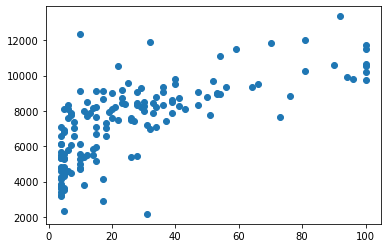

In [85]:
plt.scatter(x=tiles['nombre_venues'], y=tiles['prix_m2'])
plt.show()

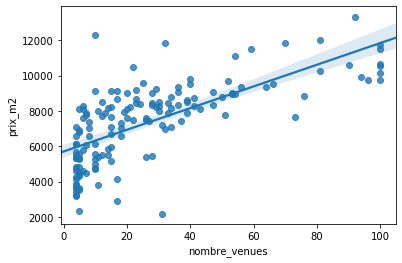

In [87]:
sns.regplot(x=tiles['nombre_venues'], y=tiles['prix_m2'])

We will use the basic LinearRegression model and measure its performance using the R2 score

In [88]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(tiles[['nombre_venues']])
y = np.asanyarray(tiles[['prix_m2']])

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=4)

regr.fit (x_train, y_train)

# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ', regr.intercept_)
print('Variance score train set: %.2f' % regr.score(x_train, y_train))
print('Variance score test set: %.2f' % regr.score(x_test, y_test))

Coefficients:  [[58.88870536]]
Intercept:  [5753.85192606]
Variance score train set: 0.49
Variance score test set: 0.49


We get and **R2 score of 0.49** which shows a **weak positive correlation** between the number of venues of interest and the price per square meters of the appartments

### IV.2 Segment the venues per tile

In [36]:
ven_cat = paris_east_venues.groupby(['Venue Category'])['nombre_venues'].sum().reset_index()
ven_cat.head()

Venue Category  nombre_venues
0    Accessories Store              2
1    Afghan Restaurant              1
2   African Restaurant             15
3  Alsatian Restaurant              2
4  American Restaurant              8

In [37]:
paris_east_venues.shape

(4415, 8)

In [38]:
paris_east_venues.to_csv('paris_east_venues_18_20200110_A.csv', index=False)
east_paris_transactions.to_csv('east_paris_transactions_18_20200110_A.csv', index=False)
tiles.to_csv('tiles_18_20200110_A.csv', index=False)

In [39]:
paris_east_venues = pd.read_csv('paris_east_venues_18_20200110_A.csv')
#paris_east_venues2.head(10)
tiles = pd.read_csv('tiles_18_20200110_A.csv')
#tiles2.head(10)
east_paris_transactions = pd.read_csv('east_paris_transactions_18_20200110_A.csv')
#east_paris_transactions2.head(10)

In [40]:
# one hot encoding
venues_onehot = pd.get_dummies(paris_east_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_onehot['tile_id'] = paris_east_venues['tile_id'] 

# move neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

print(venues_onehot.shape)
venues_onehot.head()

(4415, 324)


tile_id  Accessories Store  Afghan Restaurant  African Restaurant  \
0   00_12                  0                  0                   0   
1   00_12                  0                  0                   0   
2   00_12                  0                  0                   0   
3   00_12                  0                  0                   0   
4   00_13                  0                  0                   0   

   Alsatian Restaurant  American Restaurant  Aquarium  Arepa Restaurant  \
0                    0                    0         0                 0   
1                    0                    0         0                 0   
2                    0                    0         0                 0   
3                    0                    0         0                 0   
4                    0                    0         0                 0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   

   Asian Restaurant  Athletics & Sports  Auto Dealership  Auto Workshop  \
0                 0                   0                0              0   
1                 0                   0                0              0   
2                 0                   0                0              0   
3                 0                   0                0              0   
4                 0                   0                0              0   

   Auvergne Restaurant  BBQ Joint  Bagel Shop  Bakery  Bank  Bar  \
0                    0          0           0       1     0    0   
1                    0          0           0       0     0    0   
2                    0          0           0       0     0    0   
3                    0          0           0       0     0    0   
4                    0          0           0       0     0    0   

   Baseball Stadium  Basketball Court  Basque Restaurant  Bed & Breakfast  \
0                 0                 0                  0                0   
1                 0                 0                  0                0   
2                 0                 0                  0                0   
3                 0                 0                  0                0   
4                 0                 0                  0                0   

   Beer Bar  Beer Garden  Beer Store  Big Box Store  Bike Rental / Bike Share  \
0         0            0           0              0                         0   
1         0            0           0              0                         0   
2         0            0           0              0                         0   
3         0            0           0              0                         0   
4         0            0           0              0                         0   

   Bistro  Boarding House  Boat or Ferry  Bookstore  Botanical Garden  \
0       0               0              0          0                 0   
1       0               0              0          0                 0   
2       0               0              0          0                 0   
3       0               0              0          0                 0   
4       0               0              0          0                 0   

   Boutique  Bowling Alley  Boxing Gym  Brasserie  Brazilian Restaurant  \
0         0              0           0          0                     0   
1         0              0           0          0                     0   
2         0              0           0          0                     0   
3         0              0           0          0                     0   
4         0              0           0          0

In [41]:
venues_grouped_sum = venues_onehot.groupby('tile_id').sum().reset_index()
venues_grouped_sum.head(10)

tile_id  Accessories Store  Afghan Restaurant  African Restaurant  \
0   00_12                  0                  0                   0   
1   00_13                  0                  0                   0   
2   00_14                  0                  0                   0   
3   01_01                  0                  0                   0   
4   01_02                  0                  0                   0   
5   01_03                  0                  0                   0   
6   01_04                  0                  0                   0   
7   01_07                  0                  0                   0   
8   01_08                  0                  0                   0   
9   01_09                  0                  0                   0   

   Alsatian Restaurant  American Restaurant  Aquarium  Arepa Restaurant  \
0                    0                    0         0                 0   
1                    0                    0         0                 0   
2                    0                    0         0                 0   
3                    0                    0         0                 0   
4                    0                    0         0                 0   
5                    0                    0         0                 0   
6                    0                    0         0                 0   
7                    0                    0         0                 0   
8                    0                    0         0                 0   
9                    0                    0         0                 0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   
5                       0            0           0                    0   
6                       0            0           0                    0   
7                       0            0           0                    0   
8                       0            0           0                    0   
9                       0            0           0                    0   

   Asian Restaurant  Athletics & Sports  Auto Dealership  Auto Workshop  \
0                 0                   0                0              0   
1                 0                   0                0              0   
2                 0                   0                0              0   
3                 0                   0                0              0   
4                 0                   0                0              0   
5                 5                   0                0              0   
6                 0                   0                0              0   
7                 0                   0                0              0   
8                 0                   0                0              0   
9                 0                   0                0              0   

   Auvergne Restaurant  BBQ Joint  Bagel Shop  Bakery  Bank  Bar  \
0                    0          0           0       1     0    0   
1                    0          0           0       1     0    0   
2                    0          0           0       0     0    0   
3                    0          0           0       1     0    0   
4                    0          0           0       0     0    0   
5                    0          0           0       0     0    0   
6                    0          0           0       0     0    0   
7                    0          0           0       0     0    0   
8                    0          0           0       0     0    0   
9                    0          0           0       0     0   

In [42]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    row_categories_names = row_categories_sorted.index.values[0:num_top_venues]
    for k in range(0, num_top_venues):
        if row_categories_sorted[k] == 0:
            row_categories_names[k] = ''
        else:
            row_categories_names[k] = "{:.2f} {}".format(row_categories_sorted[k], row_categories_names[k])

    #print (row_categories_names)    
    
    #return row_categories_sorted.index.values[0:num_top_venues]
    return row_categories_names[0:num_top_venues]

In [43]:
num_top_venues = 15

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['tile_id', 'Cluster Labels']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
tiles_venues_sorted = pd.DataFrame(columns=columns)
tiles_venues_sorted['tile_id'] = venues_grouped_sum['tile_id']

for ind in np.arange(venues_grouped_sum.shape[0]):
    tiles_venues_sorted.iloc[ind, 2:] = return_most_common_venues(venues_grouped_sum.iloc[ind, :], num_top_venues)

tiles_venues_sorted.head(10)

tile_id Cluster Labels  1st Most Common Venue    2nd Most Common Venue  \
0   00_12            NaN            1.00 Bakery   1.00 French Restaurant   
1   00_13            NaN             2.00 Hotel               1.00 Plaza   
2   00_14            NaN            1.00 Market   1.00 French Restaurant   
3   01_01            NaN              2.00 Park            2.00 Bus Stop   
4   01_02            NaN             2.00 Plaza         1.00 Pizza Place   
5   01_03            NaN  5.00 Asian Restaurant  5.00 Chinese Restaurant   
6   01_04            NaN             2.00 Hotel            1.00 Bus Stop   
7   01_07            NaN         1.00 Cafeteria          1.00 Restaurant   
8   01_08            NaN            1.00 Market         1.00 Supermarket   
9   01_09            NaN             1.00 Plaza           1.00 Hotel Bar   

        3rd Most Common Venue       4th Most Common Venue  \
0               1.00 Pharmacy             1.00 Playground   
1                1.00 Stadium    1.00 Japanese Restaurant   
2               1.00 Creperie             1.00 Playground   
3      1.00 Indian Restaurant  1.00 Vietnamese Restaurant   
4                   1.00 Café                 1.00 Garden   
5  5.00 Vietnamese Restaurant   3.00 Cantonese Restaurant   
6                1.00 Stadium     1.00 Seafood Restaurant   
7   1.00 Caribbean Restaurant            1.00 Gas Station   
8              1.00 Laser Tag                   1.00 Café   
9      1.00 French Restaurant              1.00 Nightclub   

     5th Most Common Venue          6th Most Common Venue  \
0                                                           
1         1.00 Gas Station                    1.00 Bakery   
2                                                           
3  1.00 Chinese Restaurant              1.00 Squash Court   
4               1.00 Diner              1.00 Tram Station   
5     3.00 Thai Restaurant      2.00 Cambodian Restaurant   
6       1.00 Shopping Mall  1.00 Bike Rental / Bike Share   
7           1.00 Laser Tag             1.00 Boat or Ferry   
8                                                           
9         1.00 Pizza Place                                  

     7th Most Common Venue 8th Most Common Venue       9th Most Common Venue  \
0                                                                              
1   1.00 French Restaurant       1.00 Smoke Shop            1.00 Pizza Place   
2                                                                              
3   1.00 French Restaurant          1.00 Theater                 1.00 Bakery   
4  1.00 Chinese Restaurant         1.00 Bus Stop                   1.00 Park   
5                1.00 Park             1.00 Café          1.00 Grocery Store   
6        1.00 Tram Station      1.00 Supermarket  1.00 Vietnamese Restaurant   
7     1.00 Thai Restaurant            1.00 Hotel    1.00 Japanese Restaurant   
8                                                                              
9                                                                              

  10th Most Common Venue     11th Most Common Venue   12th Most Common Venue  \
0                                                                              
1                                                                              
2                                                                              
3         1.00 Brasserie                   1.00 Pub  1.00 Italian Restaurant   
4  1.00 Football Stadium               1.00 Stadium                            
5       1.00 Supermarket  1.00 Gym / Fitness Center            1.00 Tea Room   
6   1.00 Bed & Breakfast           1.00 Coffee Shop                            
7                                                                              
8                                                                              
9                                                                              

  13th Most Common Venue 14th Most Common Venue 15th Most C

In [44]:
# set number of clusters
kclusters = 12

tiles_grouped_clustering = venues_grouped_sum.drop('tile_id', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=4).fit(tiles_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:200] 

array([ 3,  3,  3,  3,  3,  6,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  8,
        9,  0,  3,  3,  3,  3,  3,  3,  3,  3,  3,  7,  3,  7,  3,  0,  3,
        3,  3,  3,  3,  3,  3,  0,  2,  3,  3,  7,  0,  0,  3,  3,  3,  3,
        3,  7,  2,  3,  7,  7,  3,  0,  3,  3,  7,  3,  3,  3,  3,  3,  3,
        7,  2,  3,  0,  2,  7,  7,  0,  7,  3,  3,  3,  3,  3,  3,  3,  4,
        4, 10,  1,  1,  7,  8,  0,  0,  3,  3,  3,  3,  3,  3,  2,  7,  7,
        0,  0,  7,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3, 11,  1,  1,  5,
        0,  0,  3,  0,  3,  3,  3,  3,  3,  3,  3,  3,  8,  7,  7,  8,  8,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  7,  0,  7,  0,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  2,  4,  3,  3,  0,  7,  3,  3,  3,
        3,  3,  3,  3,  3,  2,  2,  8,  0,  3,  0,  0,  3,  3,  3,  3,  3,
        0,  0,  3,  3,  0,  7,  3,  3,  3,  3,  3,  3,  3])

In [45]:
# add clustering labels
#tiles_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
tiles_venues_sorted['Cluster Labels'] = kmeans.labels_

tiles_merged = tiles
# merge tiles_merged with tiles_venues_sorted to add latitude/longitude for Cluster and most common venues for each tile
tiles_merged = tiles_merged.join(tiles_venues_sorted.set_index('tile_id'), on='tile_id')
tiles_merged.head(10) # check the last columns!

bins_lat  bins_long      prix_m2  nombre_transactions      lat_s  \
0         0         13  4731.721471                  131  48.811961   
1         0         14  4788.432368                   49  48.811961   
2         1          1  8161.830850                   42  48.817690   
3         1          2  7737.428188                   52  48.817690   
4         1          3  7066.006600                  112  48.817690   
5         1          4  5481.023307                   36  48.817690   
6         1          8  6578.647566                  155  48.817690   
7         1          9  6919.046132                  138  48.817690   
8         1         13  4854.089458                   52  48.817690   
9         1         14  4590.760418                   34  48.817690   

       lat_n   latitude    long_w    long_e  longitude tile_id  \
0  48.817690  48.814826  2.456692  2.466738   2.461715   00_13   
1  48.817690  48.814826  2.466738  2.476783   2.471761   00_14   
2  48.823419  48.820555  2.336146  2.346191   2.341168   01_01   
3  48.823419  48.820555  2.346191  2.356237   2.351214   01_02   
4  48.823419  48.820555  2.356237  2.366282   2.361259   01_03   
5  48.823419  48.820555  2.366282  2.376328   2.371305   01_04   
6  48.823419  48.820555  2.406464  2.416510   2.411487   01_08   
7  48.823419  48.820555  2.416510  2.426556   2.421533   01_09   
8  48.823419  48.820555  2.456692  2.466738   2.461715   01_13   
9  48.823419  48.820555  2.466738  2.476783   2.471761   01_14   

                                             address  Tile Latitude  \
0      Rue du Maréchal Leclerc, 94410, Saint-Maurice      48.814826   
1       Villa de la Grotte, 94340, Joinville-le-Pont      48.814826   
2    Allée du Bardo, 75014, Paris 14e Arrondissement      48.820555   
3     Rue Gouthière, 75013, Paris 13e Arrondissement      48.820555   
4        Rue Gandon, 75013, Paris 13e Arrondissement      48.820555   
5  Avenue de la Porte d'Ivry, 75013, Paris 13e Ar...      48.820555   
6         Rue Saint-Pierre, 94220, Charenton-le-Pont      48.820555   
7           Rue Adrien Damalix, 94410, Saint-Maurice      48.820555   
8  Autoroute de l’Est, 75012, Paris 12e Arrondiss...      48.820555   
9              Rue du Port, 94340, Joinville-le-Pont      48.820555   

   Tile Longitude  nombre_venues  Cluster Labels  1st Most Common Venue  \
0        2.461715             10               3             2.00 Hotel   
1        2.471761              4               3            1.00 Market   
2        2.341168             14               3              2.00 Park   
3        2.351214             12               3             2.00 Plaza   
4        2.361259             34               6  5.00 Asian Restaurant   
5        2.371305             12               3             2.00 Hotel   
6        2.411487              4               3            1.00 Market   
7        2.421533              5               3             1.00 Plaza   
8        2.461715              5               3          1.00 Bus Stop   
9        2.471761              6               3               1.00 Pub   

     2nd Most Common Venue       3rd Most Common Venue  \
0               1.00 Plaza                1.00 Stadium   
1   1.00 French Restaurant               1.00 Creperie   
2            2.00 Bus Stop      1.00 Indian Restaurant   
3         1.00 Pizza Place                   1.00 Café   
4  5.00 Chinese Restaurant  5.00 Vietnamese Restaurant   
5            1.00 Bus Stop                1.00 Stadium   
6         1.00 Supermarket              1.00 Laser Tag   
7           1.00 Hotel Bar      1.00 French Restaurant   
8       1.00 Train Station       1.00 Botanical Garden   
9               1.00 Hotel      1.00 French Restaurant   

        4th Most Common Venue    5th Most Common Venue  \
0    1.00 Japanese Restaurant         1.00 Gas Station   
1             1.00 Playground                            
2  1.00 Vietnamese Restaurant  1.00 Chinese Restaurant   
3              

In [46]:
venues_grouped_cluster = venues_grouped_sum
venues_grouped_cluster = venues_grouped_cluster.join(tiles_merged[['tile_id', 'Cluster Labels', 'nombre_venues']].set_index('tile_id'), on='tile_id')
venues_grouped_cluster = venues_grouped_cluster.dropna().reset_index(drop=True)
venues_grouped_cluster = venues_grouped_cluster.astype({'Cluster Labels': 'int64'}, copy=False)
venues_grouped_cluster = venues_grouped_cluster.astype({'nombre_venues': 'int64'}, copy=False)
venues_grouped_cluster.head(10)

tile_id  Accessories Store  Afghan Restaurant  African Restaurant  \
0   00_13                  0                  0                   0   
1   00_14                  0                  0                   0   
2   01_01                  0                  0                   0   
3   01_02                  0                  0                   0   
4   01_03                  0                  0                   0   
5   01_04                  0                  0                   0   
6   01_08                  0                  0                   0   
7   01_09                  0                  0                   0   
8   01_13                  0                  0                   0   
9   01_14                  0                  0                   0   

   Alsatian Restaurant  American Restaurant  Aquarium  Arepa Restaurant  \
0                    0                    0         0                 0   
1                    0                    0         0                 0   
2                    0                    0         0                 0   
3                    0                    0         0                 0   
4                    0                    0         0                 0   
5                    0                    0         0                 0   
6                    0                    0         0                 0   
7                    0                    0         0                 0   
8                    0                    0         0                 0   
9                    0                    0         0                 0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   
5                       0            0           0                    0   
6                       0            0           0                    0   
7                       0            0           0                    0   
8                       0            0           0                    0   
9                       0            0           0                    0   

   Asian Restaurant  Athletics & Sports  Auto Dealership  Auto Workshop  \
0                 0                   0                0              0   
1                 0                   0                0              0   
2                 0                   0                0              0   
3                 0                   0                0              0   
4                 5                   0                0              0   
5                 0                   0                0              0   
6                 0                   0                0              0   
7                 0                   0                0              0   
8                 0                   0                0              1   
9                 0                   0                0              0   

   Auvergne Restaurant  BBQ Joint  Bagel Shop  Bakery  Bank  Bar  \
0                    0          0           0       1     0    0   
1                    0          0           0       0     0    0   
2                    0          0           0       1     0    0   
3                    0          0           0       0     0    0   
4                    0          0           0       0     0    0   
5                    0          0           0       0     0    0   
6                    0          0           0       0     0    0   
7                    0          0           0       0     0    0   
8                    0          0           0       0     0    0   
9                    0          0           0       0     0   

In [47]:
cluster_grouped_mean = venues_grouped_cluster.drop('tile_id',1).groupby('Cluster Labels').mean().reset_index()
cluster_grouped_mean

Cluster Labels  Accessories Store  Afghan Restaurant  African Restaurant  \
0                0               0.00           0.043478            0.173913   
1                1               0.25           0.000000            0.250000   
2                2               0.00           0.000000            0.000000   
3                3               0.00           0.000000            0.024390   
4                4               0.00           0.000000            0.000000   
5                5               0.00           0.000000            2.000000   
6                6               0.00           0.000000            0.000000   
7                7               0.00           0.000000            0.150000   
8                8               0.00           0.000000            0.166667   
9                9               0.00           0.000000            0.000000   
10              10               0.00           0.000000            1.000000   
11              11               0.00           0.000000            1.000000   

    Alsatian Restaurant  American Restaurant  Aquarium  Arepa Restaurant  \
0              0.000000             0.086957  0.000000          0.000000   
1              0.000000             0.000000  0.000000          0.000000   
2              0.111111             0.222222  0.000000          0.111111   
3              0.000000             0.024390  0.012195          0.000000   
4              0.333333             0.000000  0.000000          0.000000   
5              0.000000             0.000000  0.000000          0.000000   
6              0.000000             0.000000  0.000000          0.000000   
7              0.000000             0.100000  0.000000          0.000000   
8              0.000000             0.000000  0.000000          0.000000   
9              0.000000             0.000000  0.000000          0.000000   
10             0.000000             0.000000  0.000000          0.000000   
11             0.000000             0.000000  0.000000          0.000000   

    Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                 0.000000     0.043478    0.043478             0.043478   
1                 0.250000     1.250000    0.000000             0.250000   
2                 0.111111     0.555556    0.333333             0.000000   
3                 0.000000     0.012195    0.000000             0.000000   
4                 0.000000     0.333333    0.666667             0.666667   
5                 0.000000     0.000000    0.000000             0.000000   
6                 0.000000     0.000000    0.000000             0.000000   
7                 0.050000     0.150000    0.100000             0.200000   
8                 0.000000     0.166667    0.000000             0.000000   
9                 0.000000     0.000000    0.000000             0.000000   
10                0.000000     2.000000    1.000000             0.000000   
11                0.000000     0.000000    0.000000             0.000000   

    Asian Restaurant  Athletics & Sports  Auto Dealership  Auto Workshop  \
0           0.347826            0.000000              0.0        0.00000   
1           0.500000            0.000000              0.0        0.00000   
2           0.000000            0.000000              0.0        0.00000   
3           0.121951            0.012195              0.0        0.02439   
4           1.000000            0.000000              0.0        0.00000   
5           1.000000            0.000000              0.0        0.00000   
6           5.000000            0.000000              0.0        0.00000   
7           0.600000            0.050000              0.0        0.00000   
8           0.000000            0.000000              0.0        0.00000   
9          12.000000            0.000000              0.0        0.00000   
10          1.000000            0.000000              0.0        0.00000   
11          1.000000            0.000000              0.0        0.00000 

In [48]:
cluster_labels_sorted = cluster_grouped_mean[['Cluster Labels', 'nombre_venues']].sort_values(['nombre_venues']).reset_index(drop=True)
cluster_labels_sorted

dict_cluster_rename = dict(zip(cluster_labels_sorted['Cluster Labels'], cluster_labels_sorted.index ))
dict_cluster_rename

{3: 0, 0: 1, 6: 2, 7: 3, 8: 4, 2: 5, 9: 6, 5: 7, 4: 8, 1: 9, 10: 10, 11: 11}

In [49]:
venues_grouped_cluster['Cluster Labels'].replace(to_replace=dict_cluster_rename, inplace=True)
tiles_venues_sorted['Cluster Labels'].replace(to_replace=dict_cluster_rename, inplace=True)
tiles_merged['Cluster Labels'].replace(to_replace=dict_cluster_rename, inplace=True)

In [50]:
cluster_grouped_mean['Cluster Labels'].replace(to_replace=dict_cluster_rename, inplace=True)
cluster_grouped_mean

Cluster Labels  Accessories Store  Afghan Restaurant  African Restaurant  \
0                1               0.00           0.043478            0.173913   
1                9               0.25           0.000000            0.250000   
2                5               0.00           0.000000            0.000000   
3                0               0.00           0.000000            0.024390   
4                8               0.00           0.000000            0.000000   
5                7               0.00           0.000000            2.000000   
6                2               0.00           0.000000            0.000000   
7                3               0.00           0.000000            0.150000   
8                4               0.00           0.000000            0.166667   
9                6               0.00           0.000000            0.000000   
10              10               0.00           0.000000            1.000000   
11              11               0.00           0.000000            1.000000   

    Alsatian Restaurant  American Restaurant  Aquarium  Arepa Restaurant  \
0              0.000000             0.086957  0.000000          0.000000   
1              0.000000             0.000000  0.000000          0.000000   
2              0.111111             0.222222  0.000000          0.111111   
3              0.000000             0.024390  0.012195          0.000000   
4              0.333333             0.000000  0.000000          0.000000   
5              0.000000             0.000000  0.000000          0.000000   
6              0.000000             0.000000  0.000000          0.000000   
7              0.000000             0.100000  0.000000          0.000000   
8              0.000000             0.000000  0.000000          0.000000   
9              0.000000             0.000000  0.000000          0.000000   
10             0.000000             0.000000  0.000000          0.000000   
11             0.000000             0.000000  0.000000          0.000000   

    Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                 0.000000     0.043478    0.043478             0.043478   
1                 0.250000     1.250000    0.000000             0.250000   
2                 0.111111     0.555556    0.333333             0.000000   
3                 0.000000     0.012195    0.000000             0.000000   
4                 0.000000     0.333333    0.666667             0.666667   
5                 0.000000     0.000000    0.000000             0.000000   
6                 0.000000     0.000000    0.000000             0.000000   
7                 0.050000     0.150000    0.100000             0.200000   
8                 0.000000     0.166667    0.000000             0.000000   
9                 0.000000     0.000000    0.000000             0.000000   
10                0.000000     2.000000    1.000000             0.000000   
11                0.000000     0.000000    0.000000             0.000000   

    Asian Restaurant  Athletics & Sports  Auto Dealership  Auto Workshop  \
0           0.347826            0.000000              0.0        0.00000   
1           0.500000            0.000000              0.0        0.00000   
2           0.000000            0.000000              0.0        0.00000   
3           0.121951            0.012195              0.0        0.02439   
4           1.000000            0.000000              0.0        0.00000   
5           1.000000            0.000000              0.0        0.00000   
6           5.000000            0.000000              0.0        0.00000   
7           0.600000            0.050000              0.0        0.00000   
8           0.000000            0.000000              0.0        0.00000   
9          12.000000            0.000000              0.0        0.00000   
10          1.000000            0.000000              0.0        0.00000   
11          1.000000            0.000000              0.0        0.00000 

In [51]:
cluster_grouped_mean = cluster_grouped_mean.sort_values(['Cluster Labels']).reset_index(drop=True)
cluster_grouped_mean

Cluster Labels  Accessories Store  Afghan Restaurant  African Restaurant  \
0                0               0.00           0.000000            0.024390   
1                1               0.00           0.043478            0.173913   
2                2               0.00           0.000000            0.000000   
3                3               0.00           0.000000            0.150000   
4                4               0.00           0.000000            0.166667   
5                5               0.00           0.000000            0.000000   
6                6               0.00           0.000000            0.000000   
7                7               0.00           0.000000            2.000000   
8                8               0.00           0.000000            0.000000   
9                9               0.25           0.000000            0.250000   
10              10               0.00           0.000000            1.000000   
11              11               0.00           0.000000            1.000000   

    Alsatian Restaurant  American Restaurant  Aquarium  Arepa Restaurant  \
0              0.000000             0.024390  0.012195          0.000000   
1              0.000000             0.086957  0.000000          0.000000   
2              0.000000             0.000000  0.000000          0.000000   
3              0.000000             0.100000  0.000000          0.000000   
4              0.000000             0.000000  0.000000          0.000000   
5              0.111111             0.222222  0.000000          0.111111   
6              0.000000             0.000000  0.000000          0.000000   
7              0.000000             0.000000  0.000000          0.000000   
8              0.333333             0.000000  0.000000          0.000000   
9              0.000000             0.000000  0.000000          0.000000   
10             0.000000             0.000000  0.000000          0.000000   
11             0.000000             0.000000  0.000000          0.000000   

    Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                 0.000000     0.012195    0.000000             0.000000   
1                 0.000000     0.043478    0.043478             0.043478   
2                 0.000000     0.000000    0.000000             0.000000   
3                 0.050000     0.150000    0.100000             0.200000   
4                 0.000000     0.166667    0.000000             0.000000   
5                 0.111111     0.555556    0.333333             0.000000   
6                 0.000000     0.000000    0.000000             0.000000   
7                 0.000000     0.000000    0.000000             0.000000   
8                 0.000000     0.333333    0.666667             0.666667   
9                 0.250000     1.250000    0.000000             0.250000   
10                0.000000     2.000000    1.000000             0.000000   
11                0.000000     0.000000    0.000000             0.000000   

    Asian Restaurant  Athletics & Sports  Auto Dealership  Auto Workshop  \
0           0.121951            0.012195              0.0        0.02439   
1           0.347826            0.000000              0.0        0.00000   
2           5.000000            0.000000              0.0        0.00000   
3           0.600000            0.050000              0.0        0.00000   
4           0.000000            0.000000              0.0        0.00000   
5           0.000000            0.000000              0.0        0.00000   
6          12.000000            0.000000              0.0        0.00000   
7           1.000000            0.000000              0.0        0.00000   
8           1.000000            0.000000              0.0        0.00000   
9           0.500000            0.000000              0.0        0.00000   
10          1.000000            0.000000              0.0        0.00000   
11          1.000000            0.000000              0.0        0.00000 

In [52]:
paris_east_map = paris_east()
paris_east_map = paris_price_m2 (paris_east_map)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster, nbv in zip(tiles_merged['Tile Latitude'], tiles_merged['Tile Longitude'], tiles_merged['Cluster Labels'], tiles_merged['nombre_venues']):
    label = 'Cluster C{}; Nb_venues: {}'.format(cluster, nbv)
    folium.CircleMarker(
        [lat, lon],
        radius=3+12*(nbv/100), # define how big you want the circle markers to be
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7
        ).add_to(paris_east_map)
       
paris_east_map

east_tiles.json


D:\Python\WPy64-3741\python-3.7.4.amd64\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [53]:
num_top_venues = 15

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster Labels', 'Total venues']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cluster_venues_sorted = pd.DataFrame(columns=columns)
cluster_venues_sorted['Cluster Labels'] = cluster_grouped_mean['Cluster Labels']
cluster_venues_sorted['Total venues'] = cluster_grouped_mean['nombre_venues']
print(cluster_venues_sorted.shape)

for ind in np.arange(cluster_grouped_mean.shape[0]):
   cluster_venues_sorted.iloc[ind, 2:] = return_most_common_venues(cluster_grouped_mean.iloc[ind, :-1], num_top_venues)

cluster_venues_sorted.head(12)

(12, 17)


Cluster Labels  Total venues        1st Most Common Venue  \
0                0      9.390244       0.62 French Restaurant   
1                1     28.217391                   2.04 Hotel   
2                2     34.000000        5.00 Asian Restaurant   
3                3     39.550000       4.95 French Restaurant   
4                4     48.500000                     7.00 Bar   
5                5     60.333333      11.00 French Restaurant   
6                6     73.000000  15.00 Vietnamese Restaurant   
7                7     76.000000                    21.00 Bar   
8                8     95.333333      19.00 French Restaurant   
9                9     99.000000      13.00 French Restaurant   
10              10    100.000000      14.00 French Restaurant   
11              11    100.000000            9.00 Cocktail Bar   

      2nd Most Common Venue       3rd Most Common Venue  \
0          0.55 Supermarket                  0.43 Hotel   
1    2.04 French Restaurant                    2.00 Bar   
2   5.00 Chinese Restaurant  5.00 Vietnamese Restaurant   
3                2.75 Hotel     1.70 Italian Restaurant   
4    6.00 French Restaurant            1.83 Pizza Place   
5                3.33 Hotel     3.22 Italian Restaurant   
6    12.00 Asian Restaurant        9.00 Thai Restaurant   
7          3.00 Pizza Place             3.00 Restaurant   
8                4.00 Plaza                  3.33 Hotel   
9                  6.25 Bar                 4.25 Bistro   
10               6.00 Hotel                 5.00 Bakery   
11              6.00 Bakery      6.00 French Restaurant   

        4th Most Common Venue    5th Most Common Venue  \
0               0.29 Bus Stop              0.29 Bakery   
1                   1.17 Café              1.13 Bistro   
2   3.00 Cantonese Restaurant     3.00 Thai Restaurant   
3            1.50 Coffee Shop                 1.40 Bar   
4                  1.83 Hotel              1.50 Bistro   
5                 2.56 Bakery                2.33 Café   
6      5.00 French Restaurant  4.00 Chinese Restaurant   
7      2.00 French Restaurant                2.00 Café   
8         3.33 Ice Cream Shop  3.00 Italian Restaurant   
9                  3.75 Hotel            3.25 Wine Bar   
10    5.00 Italian Restaurant      4.00 Clothing Store   
11              6.00 Wine Bar               5.00 Hotel   

        6th Most Common Venue     7th Most Common Venue  \
0                   0.26 Café    0.26 Indian Restaurant   
1                 1.00 Bakery  0.87 Japanese Restaurant   
2   2.00 Cambodian Restaurant                 1.00 Park   
3                   1.30 Café  1.25 Japanese Restaurant   
4             1.50 Restaurant               1.33 Bakery   
5                    1.67 Bar          1.44 Coffee Shop   
6            3.00 Supermarket               2.00 Bakery   
7                 2.00 Bistro         2.00 Cocktail Bar   
8                 3.00 Bakery                 2.67 Café   
9             2.75 Restaurant   2.75 Italian Restaurant   
10      3.00 Tapas Restaurant             3.00 Tea Room   
11    4.00 Italian Restaurant      4.00 Thai Restaurant   

         8th Most Common Venue     9th Most Common Venue  \
0                   0.24 Plaza  0.22 Japanese Restaurant   
1                   0.70 Plaza           0.70 Restaurant   
2                    1.00 Café        1.00 Grocery Store   
3                  1.10 Bistro               0.95 Bakery   
4   1.33 Vietnamese Restaurant   1.17 Chinese Restaurant   
5                   1.33 Plaza             1.22 Wine Bar   
6               2.00 Juice Bar          2.00 Pastry Shop   
7     2.00 Japanese Restaurant            2.00 Bookstore   
8                  2.67 Bistro                 2.33 Park   
9             2.50 Pizza Place  2.50 Japanese Restaurant   
10                  3.00 Plaza      3.00 Thai Restaurant   
11            4.00 Coffee Shop          3.00 Pizza Place   

      10th Most Common Venue     11th Most Common Venue  \
0           0.21 Pizza Plac

In [54]:
cluster_venues_sorted.to_csv('cluster_18_15_rand4_20200110_A.csv')

In [55]:
tiles_merged.head()

bins_lat  bins_long      prix_m2  nombre_transactions      lat_s  \
0         0         13  4731.721471                  131  48.811961   
1         0         14  4788.432368                   49  48.811961   
2         1          1  8161.830850                   42  48.817690   
3         1          2  7737.428188                   52  48.817690   
4         1          3  7066.006600                  112  48.817690   

       lat_n   latitude    long_w    long_e  longitude tile_id  \
0  48.817690  48.814826  2.456692  2.466738   2.461715   00_13   
1  48.817690  48.814826  2.466738  2.476783   2.471761   00_14   
2  48.823419  48.820555  2.336146  2.346191   2.341168   01_01   
3  48.823419  48.820555  2.346191  2.356237   2.351214   01_02   
4  48.823419  48.820555  2.356237  2.366282   2.361259   01_03   

                                           address  Tile Latitude  \
0    Rue du Maréchal Leclerc, 94410, Saint-Maurice      48.814826   
1     Villa de la Grotte, 94340, Joinville-le-Pont      48.814826   
2  Allée du Bardo, 75014, Paris 14e Arrondissement      48.820555   
3   Rue Gouthière, 75013, Paris 13e Arrondissement      48.820555   
4      Rue Gandon, 75013, Paris 13e Arrondissement      48.820555   

   Tile Longitude  nombre_venues  Cluster Labels  1st Most Common Venue  \
0        2.461715             10               0             2.00 Hotel   
1        2.471761              4               0            1.00 Market   
2        2.341168             14               0              2.00 Park   
3        2.351214             12               0             2.00 Plaza   
4        2.361259             34               2  5.00 Asian Restaurant   

     2nd Most Common Venue       3rd Most Common Venue  \
0               1.00 Plaza                1.00 Stadium   
1   1.00 French Restaurant               1.00 Creperie   
2            2.00 Bus Stop      1.00 Indian Restaurant   
3         1.00 Pizza Place                   1.00 Café   
4  5.00 Chinese Restaurant  5.00 Vietnamese Restaurant   

        4th Most Common Venue    5th Most Common Venue  \
0    1.00 Japanese Restaurant         1.00 Gas Station   
1             1.00 Playground                            
2  1.00 Vietnamese Restaurant  1.00 Chinese Restaurant   
3                 1.00 Garden               1.00 Diner   
4   3.00 Cantonese Restaurant     3.00 Thai Restaurant   

       6th Most Common Venue    7th Most Common Venue 8th Most Common Venue  \
0                1.00 Bakery   1.00 French Restaurant       1.00 Smoke Shop   
1                                                                             
2          1.00 Squash Court   1.00 French Restaurant          1.00 Theater   
3          1.00 Tram Station  1.00 Chinese Restaurant         1.00 Bus Stop   
4  2.00 Cambodian Restaurant                1.00 Park             1.00 Café   

  9th Most Common Venue 10th Most Common Venue     11th Most Common Venue  \
0      1.00 Pizza Place                                                     
1                                                                           
2           1.00 Bakery         1.00 Brasserie                   1.00 Pub   
3             1.00 Park  1.00 Football Stadium               1.00 Stadium   
4    1.00 Grocery Store       1.00 Supermarket  1.00 Gym / Fitness Center   

    12th Most Common Venue 13th Most Common Venue 14th Most Common Venue  \
0                                                                          
1                                                                          
2  1.00 Italian Restaurant                                                 
3                                                                          
4            1.00 Tea Room     1.00 Shopping Mall     1.00 Metro Station   

  15th Most Common Venue  
0                         
1                         
2                         
3                         
4           1.00 Stadium

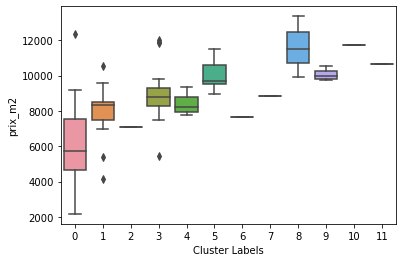

In [56]:
sns.boxplot(x="Cluster Labels", y="prix_m2", data=tiles_merged)
#plt.ylim(0, 20000)
#plt.xticks(rotation=90)
plt.autoscale(enable=True, axis='x')

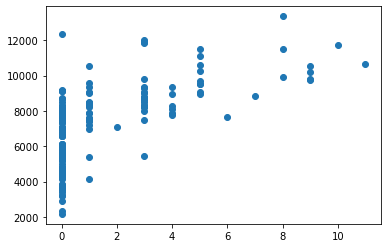

In [59]:
plt.scatter(x=tiles_merged['Cluster Labels'], y=tiles_merged['prix_m2'])
plt.show()

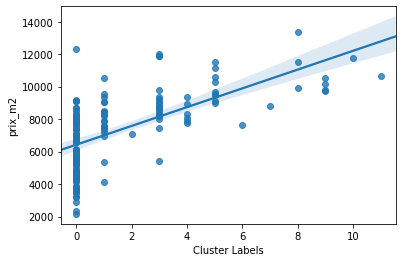

In [60]:
sns.regplot(x=tiles_merged['Cluster Labels'], y=tiles_merged['prix_m2'])


In [62]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(tiles_merged[['Cluster Labels']])
y = np.asanyarray(tiles_merged[['prix_m2']])

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=4)

regr.fit (x_train, y_train)

# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ', regr.intercept_)
print('Variance score: %.2f' % regr.score(x_train, y_train))
print('Variance score: %.2f' % regr.score(x_test, y_test))

Coefficients:  [[520.99157011]]
Intercept:  [6503.54937709]
Variance score: 0.36
Variance score: 0.48


In [63]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(tiles_merged[['Cluster Labels', 'nombre_venues']])
y = np.asanyarray(tiles_merged[['prix_m2']])

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=4)

regr.fit (x_train, y_train)

# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ', regr.intercept_)
print('Variance score: %.2f' % regr.score(x_train, y_train))
print('Variance score: %.2f' % regr.score(x_test, y_test))

Coefficients:  [[-327.4269308   88.2286697]]
Intercept:  [5491.07609327]
Variance score: 0.51
Variance score: 0.45


In [64]:
# one hot encoding
clist = list("C{:02d}".format(k) for k in list (venues_grouped_cluster['Cluster Labels']))

cluster_onehot = pd.get_dummies(clist, prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cluster_onehot['tile_id'] = venues_grouped_cluster['tile_id']
cluster_onehot['nombre_venues'] = venues_grouped_cluster['nombre_venues']


# move neighborhood column to the first column
#fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
#venues_onehot = venues_onehot[fixed_columns]

#print(cluster_onehot.shape)
cluster_onehot.head()

C00  C01  C02  C03  C04  C05  C06  C07  C08  C09  C10  C11 tile_id  \
0    1    0    0    0    0    0    0    0    0    0    0    0   00_13   
1    1    0    0    0    0    0    0    0    0    0    0    0   00_14   
2    1    0    0    0    0    0    0    0    0    0    0    0   01_01   
3    1    0    0    0    0    0    0    0    0    0    0    0   01_02   
4    0    0    1    0    0    0    0    0    0    0    0    0   01_03   

   nombre_venues  
0             10  
1              4  
2             14  
3             12  
4             34

### IV.3 Multiple linear regression based on venue categories

In [65]:
venues_grouped_cluster.merge(cluster_onehot, on='tile_id').head()

tile_id  Accessories Store  Afghan Restaurant  African Restaurant  \
0   00_13                  0                  0                   0   
1   00_14                  0                  0                   0   
2   01_01                  0                  0                   0   
3   01_02                  0                  0                   0   
4   01_03                  0                  0                   0   

   Alsatian Restaurant  American Restaurant  Aquarium  Arepa Restaurant  \
0                    0                    0         0                 0   
1                    0                    0         0                 0   
2                    0                    0         0                 0   
3                    0                    0         0                 0   
4                    0                    0         0                 0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   

   Asian Restaurant  Athletics & Sports  Auto Dealership  Auto Workshop  \
0                 0                   0                0              0   
1                 0                   0                0              0   
2                 0                   0                0              0   
3                 0                   0                0              0   
4                 5                   0                0              0   

   Auvergne Restaurant  BBQ Joint  Bagel Shop  Bakery  Bank  Bar  \
0                    0          0           0       1     0    0   
1                    0          0           0       0     0    0   
2                    0          0           0       1     0    0   
3                    0          0           0       0     0    0   
4                    0          0           0       0     0    0   

   Baseball Stadium  Basketball Court  Basque Restaurant  Bed & Breakfast  \
0                 0                 0                  0                0   
1                 0                 0                  0                0   
2                 0                 0                  0                0   
3                 0                 0                  0                0   
4                 0                 0                  0                0   

   Beer Bar  Beer Garden  Beer Store  Big Box Store  Bike Rental / Bike Share  \
0         0            0           0              0                         0   
1         0            0           0              0                         0   
2         0            0           0              0                         0   
3         0            0           0              0                         0   
4         0            0           0              0                         0   

   Bistro  Boarding House  Boat or Ferry  Bookstore  Botanical Garden  \
0       0               0              0          0                 0   
1       0               0              0          0                 0   
2       0               0              0          0                 0   
3       0               0              0          0                 0   
4       0               0              0          0                 0   

   Boutique  Bowling Alley  Boxing Gym  Brasserie  Brazilian Restaurant  \
0         0              0           0          0                     0   
1         0              0           0          0                     0   
2         0              0           0          1                     0   
3         0              0           0          0                     0   
4         0              0           0          0

In [66]:
X_features = venues_grouped_cluster.drop(['Cluster Labels', 'nombre_venues'], 1).set_index('tile_id')
#X_features = venues_grouped_cluster[['tile_id', 'nombre_venues']].set_index('tile_id')
#X_features = venues_grouped_cluster.merge(cluster_onehot, on='tile_id').drop(['Cluster Labels', 'nombre_venues_x', 'nombre_venues_y'], 1).set_index('tile_id')
#X_features = cluster_onehot.drop(['nombre_venues'], 1).set_index('tile_id')
X_features.head()

Accessories Store  Afghan Restaurant  African Restaurant  \
tile_id                                                             
00_13                    0                  0                   0   
00_14                    0                  0                   0   
01_01                    0                  0                   0   
01_02                    0                  0                   0   
01_03                    0                  0                   0   

         Alsatian Restaurant  American Restaurant  Aquarium  Arepa Restaurant  \
tile_id                                                                         
00_13                      0                    0         0                 0   
00_14                      0                    0         0                 0   
01_01                      0                    0         0                 0   
01_02                      0                    0         0                 0   
01_03                      0                    0         0                 0   

         Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
tile_id                                                                         
00_13                         0            0           0                    0   
00_14                         0            0           0                    0   
01_01                         0            0           0                    0   
01_02                         0            0           0                    0   
01_03                         0            0           0                    0   

         Asian Restaurant  Athletics & Sports  Auto Dealership  Auto Workshop  \
tile_id                                                                         
00_13                   0                   0                0              0   
00_14                   0                   0                0              0   
01_01                   0                   0                0              0   
01_02                   0                   0                0              0   
01_03                   5                   0                0              0   

         Auvergne Restaurant  BBQ Joint  Bagel Shop  Bakery  Bank  Bar  \
tile_id                                                                  
00_13                      0          0           0       1     0    0   
00_14                      0          0           0       0     0    0   
01_01                      0          0           0       1     0    0   
01_02                      0          0           0       0     0    0   
01_03                      0          0           0       0     0    0   

         Baseball Stadium  Basketball Court  Basque Restaurant  \
tile_id                                                          
00_13                   0                 0                  0   
00_14                   0                 0                  0   
01_01                   0                 0                  0   
01_02                   0                 0                  0   
01_03                   0                 0                  0   

         Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Big Box Store  \
tile_id                                                                      
00_13                  0         0            0           0              0   
00_14                  0         0            0           0              0   
01_01                  0         0            0           0              0   
01_02                  0         0            0           0              0   
01_03                  0         0            0           0              0   

         Bike Rental / Bike Share  Bistro  Boarding House  Boat or Ferry  \
tile_id                                                                    
00_13                           0       0               0              0   
00_14                           0       0               0       

In [67]:
venues_grouped_cluster.head()

tile_id  Accessories Store  Afghan Restaurant  African Restaurant  \
0   00_13                  0                  0                   0   
1   00_14                  0                  0                   0   
2   01_01                  0                  0                   0   
3   01_02                  0                  0                   0   
4   01_03                  0                  0                   0   

   Alsatian Restaurant  American Restaurant  Aquarium  Arepa Restaurant  \
0                    0                    0         0                 0   
1                    0                    0         0                 0   
2                    0                    0         0                 0   
3                    0                    0         0                 0   
4                    0                    0         0                 0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   

   Asian Restaurant  Athletics & Sports  Auto Dealership  Auto Workshop  \
0                 0                   0                0              0   
1                 0                   0                0              0   
2                 0                   0                0              0   
3                 0                   0                0              0   
4                 5                   0                0              0   

   Auvergne Restaurant  BBQ Joint  Bagel Shop  Bakery  Bank  Bar  \
0                    0          0           0       1     0    0   
1                    0          0           0       0     0    0   
2                    0          0           0       1     0    0   
3                    0          0           0       0     0    0   
4                    0          0           0       0     0    0   

   Baseball Stadium  Basketball Court  Basque Restaurant  Bed & Breakfast  \
0                 0                 0                  0                0   
1                 0                 0                  0                0   
2                 0                 0                  0                0   
3                 0                 0                  0                0   
4                 0                 0                  0                0   

   Beer Bar  Beer Garden  Beer Store  Big Box Store  Bike Rental / Bike Share  \
0         0            0           0              0                         0   
1         0            0           0              0                         0   
2         0            0           0              0                         0   
3         0            0           0              0                         0   
4         0            0           0              0                         0   

   Bistro  Boarding House  Boat or Ferry  Bookstore  Botanical Garden  \
0       0               0              0          0                 0   
1       0               0              0          0                 0   
2       0               0              0          0                 0   
3       0               0              0          0                 0   
4       0               0              0          0                 0   

   Boutique  Bowling Alley  Boxing Gym  Brasserie  Brazilian Restaurant  \
0         0              0           0          0                     0   
1         0              0           0          0                     0   
2         0              0           0          1                     0   
3         0              0           0          0                     0   
4         0              0           0          0

In [68]:
X_columns = pd.DataFrame(data={'Venue type':list(X_features.columns)})
X_columns.tail()

Venue type
318    Wings Joint
319  Women's Store
320    Yoga Studio
321            Zoo
322    Zoo Exhibit

In [69]:
Y = tiles_merged[['tile_id', 'prix_m2']].set_index('tile_id')
Y.head()

prix_m2
tile_id             
00_13    4731.721471
00_14    4788.432368
01_01    8161.830850
01_02    7737.428188
01_03    7066.006600

Use Ridge algorithm with Cross Validation embedded - multiple linear regression based on venue types

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, Y, test_size=0.30, random_state=4)

In [71]:
reg = linear_model.RidgeCV(alphas=np.logspace(-5, 5, 25))
reg.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e-05, 2.61015722e-05, 6.81292069e-05, 1.77827941e-04,
       4.64158883e-04, 1.21152766e-03, 3.16227766e-03, 8.25404185e-03,
       2.15443469e-02, 5.62341325e-02, 1.46779927e-01, 3.83118685e-01,
       1.00000000e+00, 2.61015722e+00, 6.81292069e+00, 1.77827941e+01,
       4.64158883e+01, 1.21152766e+02, 3.16227766e+02, 8.25404185e+02,
       2.15443469e+03, 5.62341325e+03, 1.46779927e+04, 3.83118685e+04,
       1.00000000e+05]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [72]:

#regr = linear_model.Ridge(alpha=20)
#x = np.asanyarray(venues_grouped_cluster.drop(['tile_id', 'Cluster Labels', 'nombre_venues'], 1))
#y = np.asanyarray(tiles_merged[['prix_m2']])
#regr.fit (X_train_all, y_train_all)
# The coefficients
#print ('alpha: ', alpha)
print ('Intercept: ', reg.intercept_)
print ('Alpha: ', reg.alpha_)
print('Variance score train: %.2f' % reg.score(X_train, y_train))
print('Variance score test: %.2f' % reg.score(X_test, y_test))
    
X_columns['Coefficients'] = reg.coef_[0]
X_columns.head()

Intercept:  [5945.8833513]
Alpha:  121.15276586285901
Variance score train: 0.59
Variance score test: 0.57


Venue type  Coefficients
0    Accessories Store     -4.318596
1    Afghan Restaurant     10.325670
2   African Restaurant     13.221082
3  Alsatian Restaurant      3.702527
4  American Restaurant    -10.358957

In [73]:
X_columns.sort_values(by=['Coefficients'])


Venue type  Coefficients
111                      Fast Food Restaurant   -123.100948
131                               Gas Station    -58.408445
137                               Golf Course    -51.248432
248                                 Rock Club    -38.428492
52                                  Cafeteria    -33.124667
99                           Doner Restaurant    -32.078534
40                             Breakfast Spot    -31.991072
267                               Snack Place    -31.659262
89                               Dance Studio    -31.255225
203                               Music Venue    -29.999816
135                                 Gift Shop    -29.299221
311                          Video Game Store    -28.847338
262                             Shopping Mall    -28.340290
155                            Ice Cream Shop    -25.561944
17                                 Bagel Shop    -24.553031
290                                Taco Place    -22.976408
268                              Soccer Field    -22.002208
172                         Korean Restaurant    -21.434515
214             Paper / Office Supplies Store    -21.340756
127                    Furniture / Home Store    -21.329883
68                             Chocolate Shop    -21.294195
176                                Laundromat    -19.553399
14                              Auto Workshop    -19.546818
167                                 Juice Bar    -19.415376
298              Theme Park Ride / Attraction    -19.329895
126                              Funeral Home    -18.584471
265                              Skating Rink    -18.230788
80                 Construction & Landscaping    -17.891424
259                        Seafood Restaurant    -17.418922
50                                   Bus Stop    -16.851784
98                                  Dive Spot    -16.164780
199                             Movie Theater    -15.741643
159                              Intersection    -15.487055
305                             Train Station    -14.429225
160                                 Irish Pub    -13.929090
284                                Street Art    -13.929090
60                                Candy Store    -13.851315
193                         Mobile Phone Shop    -13.079653
266                                Smoke Shop    -12.695958
183                                    Market    -12.291361
292                             Tattoo Parlor    -12.238666
309                        Turkish Restaurant    -12.034873
191                 Middle Eastern Restaurant    -11.992866
239                               Record Shop    -10.821408
57                                 Campground    -10.633089
22                           Basketball Court    -10.633089
4                         American Restaurant    -10.358957
71                               Climbing Gym    -10.208138
51                                    Butcher    -10.185396
287                          Sushi Restaurant     -9.676231
251                               Salad Place     -9.572037
320                               Yoga Studio     -9.391890
88                               Cycle Studio     -9.391890
307                         Trattoria/Osteria     -9.391890
168                               Karaoke Bar     -9.391890
116                         Fondue Restaurant     -9.391890
24                            Bed & Breakfast     -8.932313
49                                Bus Station     -8.559988
97                                   Dive Bar     -8.374495
209                                    Office     -8.374495
244                                    Resort     -8.374495
42                                    Brewery     -6.535465
227                                Playground     -6.459101
16                                  BBQ Joint     -6.376468
180                                    Lounge     -6.346091
44                            Bubble Tea Shop     -6.016875
194            

In [93]:
positive_venue_list = X_columns[X_columns['Coefficients'] > 60]

positive_venue_list.head(100)
paris_east_venues.head(50)

tile_id  Tile Latitude  Tile Longitude  \
0    00_12      48.814826        2.451669   
1    00_12      48.814826        2.451669   
2    00_12      48.814826        2.451669   
3    00_12      48.814826        2.451669   
4    00_13      48.814826        2.461715   
5    00_13      48.814826        2.461715   
6    00_13      48.814826        2.461715   
7    00_13      48.814826        2.461715   
8    00_13      48.814826        2.461715   
9    00_13      48.814826        2.461715   
10   00_13      48.814826        2.461715   
11   00_13      48.814826        2.461715   
12   00_13      48.814826        2.461715   
13   00_13      48.814826        2.461715   
14   00_14      48.814826        2.471761   
15   00_14      48.814826        2.471761   
16   00_14      48.814826        2.471761   
17   00_14      48.814826        2.471761   
18   01_01      48.820555        2.341168   
19   01_01      48.820555        2.341168   
20   01_01      48.820555        2.341168   
21   01_01      48.820555        2.341168   
22   01_01      48.820555        2.341168   
23   01_01      48.820555        2.341168   
24   01_01      48.820555        2.341168   
25   01_01      48.820555        2.341168   
26   01_01      48.820555        2.341168   
27   01_01      48.820555        2.341168   
28   01_01      48.820555        2.341168   
29   01_01      48.820555        2.341168   
30   01_01      48.820555        2.341168   
31   01_01      48.820555        2.341168   
32   01_02      48.820555        2.351214   
33   01_02      48.820555        2.351214   
34   01_02      48.820555        2.351214   
35   01_02      48.820555        2.351214   
36   01_02      48.820555        2.351214   
37   01_02      48.820555        2.351214   
38   01_02      48.820555        2.351214   
39   01_02      48.820555        2.351214   
40   01_02      48.820555        2.351214   
41   01_02      48.820555        2.351214   
42   01_02      48.820555        2.351214   
43   01_02      48.820555        2.351214   
44   01_03      48.820555        2.361259   
45   01_03      48.820555        2.361259   
46   01_03      48.820555        2.361259   
47   01_03      48.820555        2.361259   
48   01_03      48.820555        2.361259   
49   01_03      48.820555        2.361259   

                                                Venue  Venue Latitude  \
0                                                Paul       48.812874   
1                         Pharmacie Place Montgolfier       48.817225   
2                                  Square Jean Biguet       48.815705   
3                                    Le Pavillon Bleu       48.816588   
4                                   Place Montgolfier       48.815858   
5                           ibis Budget Saint-Maurice       48.815957   
6                                                  BP       48.813528   
7                                    Bistro de Lacaze       48.815573   
8                                          La Parisse       48.814788   
9                                              Sakura       48.815382   
10                                         Pizza Vino       48.815651   
11                                 Tabac Quach & Tang       48.815402   
12   Hotel Hipotel Paris Hippodrome Joinville-le-Pont       48.818300   
13               Stade Municipal Jean-Pierre Garchery       48.818218   
14                                        La Mascotte       48.817980   
15                     Le Marché De Joinville Le Pont       48.816197   
16                                   Parc de l'Abbaye       48.812666   
17                                        La Crêperie       48.816767   
18                       La Fabrique aux Gourmandises       48.820959   
19                             Le Pavillon Montsouris       48.822223   
20                                    Parc Montsouris       48.822307   
21       Parc de la Cité Internationale Universitaire       48.818503   
22                  Théâtre 

In [106]:
positive_venues=paris_east_venues.merge(positive_venue_list, left_on='Venue Category', right_on='Venue type')
positive_venues=positive_venues.merge(tiles[['tile_id']], on='tile_id')
print(positive_venues.shape)
print(paris_east_venues.shape)

(1484, 10)
(4415, 8)


In [108]:
def paris_tiles (paris_map):

    workfile = r'east_tiles.json'
    print(workfile)

    folium.GeoJson(
        workfile
    ).add_to(paris_map)

    return paris_map

In [115]:
paris_east_map = paris_east()
paris_east_map = paris_price_m2 (paris_east_map)
paris_east_map

east_tiles.json


D:\Python\WPy64-3741\python-3.7.4.amd64\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [117]:
from folium.plugins import HeatMap

paris_east_map = paris_east()
paris_east_map = paris_tiles (paris_east_map)

good_latitudes = positive_venues['Venue Latitude'].values
good_longitudes = positive_venues['Venue Longitude'].values

good_locations = [[lat, lon] for lat, lon in zip(good_latitudes, good_longitudes)]

HeatMap(good_locations).add_to(paris_east_map)

paris_east_map

east_tiles.json


In [77]:
tiles_merged[tiles_merged['tile_id']=='08_10'].head(10)

bins_lat  bins_long      prix_m2  nombre_transactions      lat_s  \
84         8         10  5304.414731                   51  48.857794   

        lat_n   latitude    long_w    long_e  longitude tile_id  \
84  48.863523  48.860658  2.426556  2.436601   2.431578   08_10   

                                address  Tile Latitude  Tile Longitude  \
84  Rue Désiré Préaux, 93100, Montreuil      48.860658        2.431578   

    nombre_venues  Cluster Labels   1st Most Common Venue  \
84             10               0  2.00 French Restaurant   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
84           2.00 Bistro     1.00 Concert Hall      1.00 Pizza Place   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
84            1.00 Plaza   1.00 Farmers Market    1.00 Shopping Mall   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
84        1.00 Wine Shop                                                

   11th Most Common Venue 12th Most Common Venue 13th Most Common Venue  \
84                                                                        

   14th Most Common Venue 15th Most Common Venue  
84

In [78]:
#X_features = venues_grouped_cluster.drop(['Cluster Labels', 'nombre_venues'], 1).set_index('tile_id')
#X_features = venues_grouped_cluster[['tile_id', 'nombre_venues']].set_index('tile_id')
#X_features = venues_grouped_cluster.merge(cluster_onehot, on='tile_id').drop(['Cluster Labels', 'nombre_venues_x', 'nombre_venues_y'], 1).set_index('tile_id')
X_features = cluster_onehot.drop(['nombre_venues'], 1).set_index('tile_id')
X_features.head()

C00  C01  C02  C03  C04  C05  C06  C07  C08  C09  C10  C11
tile_id                                                            
00_13      1    0    0    0    0    0    0    0    0    0    0    0
00_14      1    0    0    0    0    0    0    0    0    0    0    0
01_01      1    0    0    0    0    0    0    0    0    0    0    0
01_02      1    0    0    0    0    0    0    0    0    0    0    0
01_03      0    0    1    0    0    0    0    0    0    0    0    0

In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, Y, test_size=0.30, random_state=4)

reg = linear_model.RidgeCV(alphas=np.logspace(-5, 5, 25))
reg.fit(X_train, y_train)

print ('Intercept: ', reg.intercept_)
print ('Alpha: ', reg.alpha_)
print('Variance score train: %.2f' % reg.score(X_train, y_train))
print('Variance score test: %.2f' % reg.score(X_test, y_test))
    
#X_columns['Coefficients'] = reg.coef_[0]
#X_columns.head()

Intercept:  [8803.62990861]
Alpha:  1.0
Variance score train: 0.43
Variance score test: 0.55


In [ ]:
X_train.head()

## V. Results and Discussion <a name="results"></a>

## VI. Conclusion <a name="conclusion"></a>

## Appendices

In [ ]:
east_paris_cities= east_paris_transactions.groupby(['code_postal', 'nom_commune'])['prix_m2'].median().reset_index()
east_paris_cities.insert(loc=len(east_paris_cities.columns), column='latitude', value=0.0)
east_paris_cities.insert(loc=len(east_paris_cities.columns), column='longitude', value=0.0)

In [ ]:
from folium import plugins

# let's start again with a clean copy of the map of San Francisco
sanfran_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(sanfran_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(df_incidents.Y, df_incidents.X, df_incidents.Category):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents)

# display map
sanfran_map